# 🎯 High-Fidelity GraphSAGE (HiFi-GraphSAGE) for Smart Contract Vulnerability Detection

## Methodology Overview

This notebook implements the **HiFi-GraphSAGE** framework following the research methodology:

### Pipeline Architecture:
1. **Solidity Source Code** → Compilation → **EVM Bytecode**
2. **EVM Bytecode** → Disassembly → **Opcode Sequence**
3. **Opcode Sequence** → Basic Block Identification → **High-Fidelity CFG**
4. **HF-CFG** → Node Feature Extraction (Opcode Embeddings) → **Graph Data**
5. **Graph Data** → GraphSAGE Model → **Vulnerability Classification**

### Key Components:
- **High-Fidelity Control Flow Graph (HF-CFG)**: Preserves semantic content of EVM opcodes
- **Opcode Embeddings**: Word2Vec/FastText for opcode semantics
- **GraphSAGE (Graph Sample and Aggregate)**: Inductive learning for vulnerability detection

### Datasets:
- **ESC Dataset**: 307,396 functions from 40,932 Ethereum smart contracts
  - 5,013 functions with call.value (Re-entrancy vulnerability)
  - 4,833 functions with block.timestamp (Timestamp dependence vulnerability)
- **VSC Dataset**: 13,761 functions from 4,170 VNT Chain smart contracts
  - 2,925 functions with loop statements

### Target Vulnerabilities:
- **Re-entrancy** (call.value)
- **Timestamp Dependence** (block.timestamp)
- **Loop Statements** (VSC dataset)

## 1. Environment Setup and Dependencies

In [66]:
# =============================================================================
# CELL 1: INSTALL DEPENDENCIES
# =============================================================================
!pip install -q torch-geometric pyevmasm gensim
!pip install -q pandas scikit-learn matplotlib seaborn tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import random
import numpy as np
import hashlib
import urllib.request
import zipfile
import io
import json  # Thêm json để parse dataset
from collections import Counter, defaultdict
from tqdm import tqdm

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import Batch
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

# Try to import pyevmasm for EVM disassembly
try:
    from pyevmasm import disassemble_all, disassemble_one
    PYEVMASM_AVAILABLE = True
    print("✅ pyevmasm available for EVM disassembly")
except ImportError:
    PYEVMASM_AVAILABLE = False
    print("⚠️ pyevmasm not available, using regex-based bytecode analysis")

# Try to import gensim for Word2Vec embeddings
try:
    from gensim.models import Word2Vec
    GENSIM_AVAILABLE = True
    print("✅ gensim available for opcode embeddings")
except ImportError:
    GENSIM_AVAILABLE = False
    print("⚠️ gensim not available, using one-hot encoding")

# Seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ PyTorch: {torch.__version__}")
print(f"✅ Device: {device}")

✅ pyevmasm available for EVM disassembly
✅ gensim available for opcode embeddings

✅ PyTorch: 2.9.0+cu126
✅ Device: cuda


## 2. Configuration and Hyperparameters

In [67]:
# =============================================================================
# CELL 2: CONFIGURATION
# =============================================================================
print("=" * 80)
print("⚙️ CONFIGURATION - HiFi-GraphSAGE METHODOLOGY")
print("=" * 80)

# Directories
BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data", "hifi_graphsage")
MODEL_SAVE_DIR = os.path.join(BASE_DIR, "saved_models")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Dataset Selection: 'ESC' or 'VSC'
DATASET_NAME = 'VSC'  # Changed to 'VSC' to use VNT Chain dataset from GNNSCVulDetector

# Target Vulnerabilities (ESC Dataset)
# ESC: Re-entrancy (call.value), Timestamp Dependence (block.timestamp)
# VSC: Loop Statements
if DATASET_NAME == 'ESC':
    TARGET_VULNS = ['Re-entrancy', 'Timestamp Dependence']
    VULN_LABELS = {'Re-entrancy': 0, 'Timestamp Dependence': 1}
    NUM_CLASSES = 2
elif DATASET_NAME == 'VSC':
    TARGET_VULNS = ['No Loop', 'Has Loop']
    VULN_LABELS = {'No Loop': 0, 'Has Loop': 1}
    NUM_CLASSES = 2
else:
    raise ValueError(f"Unknown dataset: {DATASET_NAME}")

# EVM Opcode Vocabulary (for High-Fidelity feature extraction)
EVM_OPCODES = {
    # Arithmetic
    'STOP': 0, 'ADD': 1, 'MUL': 2, 'SUB': 3, 'DIV': 4, 'SDIV': 5, 'MOD': 6, 
    'SMOD': 7, 'ADDMOD': 8, 'MULMOD': 9, 'EXP': 10, 'SIGNEXTEND': 11,
    # Comparison
    'LT': 12, 'GT': 13, 'SLT': 14, 'SGT': 15, 'EQ': 16, 'ISZERO': 17,
    # Bitwise
    'AND': 18, 'OR': 19, 'XOR': 20, 'NOT': 21, 'BYTE': 22, 'SHL': 23, 'SHR': 24, 'SAR': 25,
    # Hash
    'SHA3': 26, 'KECCAK256': 26,
    # Environment
    'ADDRESS': 27, 'BALANCE': 28, 'ORIGIN': 29, 'CALLER': 30, 'CALLVALUE': 31,
    'CALLDATALOAD': 32, 'CALLDATASIZE': 33, 'CALLDATACOPY': 34, 'CODESIZE': 35,
    'CODECOPY': 36, 'GASPRICE': 37, 'EXTCODESIZE': 38, 'EXTCODECOPY': 39,
    'RETURNDATASIZE': 40, 'RETURNDATACOPY': 41, 'EXTCODEHASH': 42,
    # Block
    'BLOCKHASH': 43, 'COINBASE': 44, 'TIMESTAMP': 45, 'NUMBER': 46, 
    'DIFFICULTY': 47, 'GASLIMIT': 48, 'CHAINID': 49, 'SELFBALANCE': 50, 'BASEFEE': 51,
    # Stack/Memory/Storage
    'POP': 52, 'MLOAD': 53, 'MSTORE': 54, 'MSTORE8': 55, 'SLOAD': 56, 'SSTORE': 57,
    # Control Flow
    'JUMP': 58, 'JUMPI': 59, 'PC': 60, 'MSIZE': 61, 'GAS': 62, 'JUMPDEST': 63,
    # Push operations (64-95)
    'PUSH1': 64, 'PUSH2': 65, 'PUSH32': 95,
    # Dup operations (96-111)
    'DUP1': 96, 'DUP16': 111,
    # Swap operations (112-127)
    'SWAP1': 112, 'SWAP16': 127,
    # Log operations
    'LOG0': 128, 'LOG1': 129, 'LOG2': 130, 'LOG3': 131, 'LOG4': 132,
    # System
    'CREATE': 133, 'CALL': 134, 'CALLCODE': 135, 'RETURN': 136,
    'DELEGATECALL': 137, 'CREATE2': 138, 'STATICCALL': 139,
    'REVERT': 140, 'INVALID': 141, 'SELFDESTRUCT': 142,
}
VOCAB_SIZE = 150  # Total opcode vocabulary size

# Feature Selection: Loại bỏ TIMESTAMP feature để tránh overfitting khi train các lỗ hổng khác
# Set True để loại bỏ feature 12 (TIMESTAMP) - Khuyến nghị khi train Re-entrancy hoặc các lỗ hổng khác
REMOVE_TIMESTAMP_FEATURE = True  # Set False nếu muốn giữ feature TIMESTAMP

# High-Fidelity Feature Dimensions
# 150 (BoW opcode counts) + 15 (semantic features) = 165 total
# Nếu REMOVE_TIMESTAMP_FEATURE = True: 150 + 14 = 164 total
NUM_BOW_FEATURES = 150
NUM_SEMANTIC_FEATURES = 15 if not REMOVE_TIMESTAMP_FEATURE else 14
NUM_NODE_FEATURES = NUM_BOW_FEATURES + NUM_SEMANTIC_FEATURES

# Model Architecture (GraphSAGE) - Giảm capacity để chống overfitting
HIDDEN_CHANNELS = 32      # Reduced from 64 to prevent overfitting
NUM_SAGE_LAYERS = 2       # Number of GraphSAGE layers
DROPOUT = 0.6             # Increased dropout to prevent overfitting (was 0.5)

# Training Hyperparameters (Using Adam with standard settings)
LEARNING_RATE = 3e-4      # Further reduced learning rate (was 5e-4)
WEIGHT_DECAY = 2e-3       # Further increased weight decay (was 1e-3)
BATCH_SIZE = 64           # Increased batch size for more stable training
EPOCHS = 100              # Reduced from 200
PATIENCE = 10             # More aggressive early stopping (was 15)

# Class Weights (Simplified - equal weights)
CLASS_WEIGHT_0 = 1.0    # Equal weight for class 0
CLASS_WEIGHT_1 = 1.0    # Equal weight for class 1

# Thresholds
THRESHOLD = 0.5       # Default threshold

print(f"""
📋 Configuration Summary:
   Dataset: {DATASET_NAME}
   Target Vulnerabilities: {TARGET_VULNS}
   Node Features: {NUM_NODE_FEATURES} ({NUM_BOW_FEATURES} BoW + {NUM_SEMANTIC_FEATURES} semantic)
   Remove TIMESTAMP Feature: {REMOVE_TIMESTAMP_FEATURE} {'(Feature 12 removed)' if REMOVE_TIMESTAMP_FEATURE else '(Feature 12 included)'}
   
   Model Architecture (GraphSAGE):
   - Hidden Channels: {HIDDEN_CHANNELS}
   - GraphSAGE Layers: {NUM_SAGE_LAYERS}
   - Dropout: {DROPOUT}
   
   Training (Adam Optimizer):
   - Learning Rate: {LEARNING_RATE}
   - Weight Decay: {WEIGHT_DECAY}
   - Batch Size: {BATCH_SIZE}
   - Epochs: {EPOCHS}
   
   Threshold: {THRESHOLD}
""")

⚙️ CONFIGURATION - HiFi-GraphSAGE METHODOLOGY

📋 Configuration Summary:
   Dataset: VSC
   Target Vulnerabilities: ['No Loop', 'Has Loop']
   Node Features: 164 (150 BoW + 14 semantic)
   Remove TIMESTAMP Feature: True (Feature 12 removed)
   
   Model Architecture (GraphSAGE):
   - Hidden Channels: 32
   - GraphSAGE Layers: 2
   - Dropout: 0.6
   
   Training (Adam Optimizer):
   - Learning Rate: 0.0003
   - Weight Decay: 0.002
   - Batch Size: 64
   - Epochs: 100
   
   Threshold: 0.5



## 3. High-Fidelity Control Flow Graph (HF-CFG) Builder

The HF-CFG is constructed through:
1. **Disassembly**: Raw EVM bytecode → Opcode sequence
2. **Basic Block Identification**: Partition into basic blocks (single entry, single exit)
3. **Graph Construction**: Nodes = basic blocks, Edges = control flow transitions
4. **High-Fidelity Feature Extraction**: 
   - Bag-of-Opcodes (150 dims)
   - Semantic features (15 dims) for vulnerability patterns

In [68]:
# =============================================================================
# CELL 3: HIGH-FIDELITY CFG BUILDER
# =============================================================================
print("=" * 80)
print("🔧 HIGH-FIDELITY CONTROL FLOW GRAPH (HF-CFG) BUILDER")
print("=" * 80)

class HiFiCFGBuilder:
    """
    High-Fidelity Control Flow Graph Builder
    
    Implements the methodology:
    1. Disassembly: EVM bytecode → opcode sequence
    2. Basic Block Identification
    3. Graph Construction with control flow edges
    4. High-Fidelity Feature Extraction (BoW + Semantic)
    """
    
    def __init__(self, remove_timestamp_feature=False):
        self.opcode_vocab = EVM_OPCODES
        self.vocab_size = VOCAB_SIZE
        self.remove_timestamp_feature = remove_timestamp_feature
        self.num_semantic = NUM_SEMANTIC_FEATURES
        self.total_features = NUM_NODE_FEATURES
        
        # Terminator opcodes for basic block splitting
        self.terminators = {'JUMP', 'JUMPI', 'STOP', 'RETURN', 'REVERT', 'INVALID', 'SELFDESTRUCT'}
        
        # Vulnerability-relevant opcodes
        self.reentrancy_opcodes = {'CALL', 'CALLCODE', 'DELEGATECALL', 'STATICCALL'}
        self.arithmetic_opcodes = {'ADD', 'SUB', 'MUL', 'DIV', 'EXP', 'ADDMOD', 'MULMOD'}
        self.storage_opcodes = {'SLOAD', 'SSTORE'}
        self.dangerous_opcodes = {'SELFDESTRUCT', 'ORIGIN', 'DELEGATECALL'}
    
    def disassemble_bytecode(self, bytecode_hex):
        """
        Disassemble EVM bytecode into opcode sequence
        Returns list of instruction objects or tuples (name, operand, pc)
        """
        if bytecode_hex.startswith("0x"):
            bytecode_hex = bytecode_hex[2:]
        
        # Clean bytecode
        bytecode_hex = ''.join(c for c in bytecode_hex if c in '0123456789abcdefABCDEF')
        
        if len(bytecode_hex) < 2:
            return []
        
        if PYEVMASM_AVAILABLE:
            try:
                bytecode = bytes.fromhex(bytecode_hex)
                instructions = list(disassemble_all(bytecode))
                return instructions
            except Exception:
                pass
        
        # Fallback: Simple regex-based parsing
        return self._simple_disassemble(bytecode_hex)
    
    def _simple_disassemble(self, bytecode_hex):
        """Simple bytecode parsing without pyevmasm"""
        instructions = []
        
        # Common opcode patterns in bytecode
        opcode_patterns = {
            'f1': 'CALL', 'f2': 'CALLCODE', 'f4': 'DELEGATECALL', 'fa': 'STATICCALL',
            '54': 'SLOAD', '55': 'SSTORE',
            '01': 'ADD', '02': 'MUL', '03': 'SUB', '04': 'DIV', '0a': 'EXP',
            '56': 'JUMP', '57': 'JUMPI', '5b': 'JUMPDEST',
            '00': 'STOP', 'f3': 'RETURN', 'fd': 'REVERT', 'ff': 'SELFDESTRUCT',
            '34': 'CALLVALUE', '32': 'ORIGIN', '33': 'CALLER',
            '42': 'TIMESTAMP', '43': 'NUMBER',
            '20': 'SHA3', '10': 'LT', '11': 'GT', '14': 'EQ', '15': 'ISZERO',
        }
        
        i = 0
        pc = 0
        while i < len(bytecode_hex) - 1:
            opcode = bytecode_hex[i:i+2].lower()
            
            # Check if it's a PUSH instruction
            if opcode.startswith('6') or opcode.startswith('7'):
                push_size = int(opcode, 16) - 0x5f
                instructions.append(('PUSH' + str(push_size), bytecode_hex[i+2:i+2+push_size*2], pc))
                i += 2 + push_size * 2
                pc += 1 + push_size
            elif opcode in opcode_patterns:
                instructions.append((opcode_patterns[opcode], '', pc))
                i += 2
                pc += 1
            else:
                i += 2
                pc += 1
        
        return instructions
    
    def build_cfg(self, bytecode_or_instructions):
        """
        Build High-Fidelity Control Flow Graph
        
        Returns: nx.DiGraph with basic blocks as nodes
        """
        # Get instructions
        if isinstance(bytecode_or_instructions, str):
            instructions = self.disassemble_bytecode(bytecode_or_instructions)
        else:
            instructions = bytecode_or_instructions
        
        if not instructions:
            return nx.DiGraph()
        
        cfg = nx.DiGraph()
        blocks = []
        current_block = []
        pc_to_block_idx = {}
        
        # Partition into basic blocks
        for instr in instructions:
            # Handle both pyevmasm objects and tuples
            if hasattr(instr, 'name'):
                name = instr.name
                pc = instr.pc
            else:
                name, _, pc = instr
            
            # Start new block at JUMPDEST
            if name == 'JUMPDEST' and current_block:
                blocks.append(current_block)
                current_block = []
            
            current_block.append(instr)
            
            # End block at terminators
            if name in self.terminators:
                blocks.append(current_block)
                current_block = []
        
        if current_block:
            blocks.append(current_block)
        
        # Add nodes with features
        for idx, block in enumerate(blocks):
            if not block:
                continue
            
            # Get start PC
            if hasattr(block[0], 'pc'):
                start_pc = block[0].pc
            else:
                start_pc = block[0][2]
            
            pc_to_block_idx[start_pc] = idx
            cfg.add_node(idx, instructions=block, start_pc=start_pc)
        
        # Add edges based on control flow
        for idx, block in enumerate(blocks):
            if not block:
                continue
            
            # Get last instruction
            last_instr = block[-1]
            if hasattr(last_instr, 'name'):
                last_name = last_instr.name
            else:
                last_name = last_instr[0]
            
            # Fallthrough edge (if not a terminal jump)
            if last_name not in {'STOP', 'RETURN', 'REVERT', 'INVALID', 'SELFDESTRUCT', 'JUMP'}:
                if idx + 1 < len(blocks):
                    cfg.add_edge(idx, idx + 1, type='fallthrough')
            
            # Jump edges
            if last_name in {'JUMP', 'JUMPI'}:
                target_pc = self._resolve_jump_target(block)
                if target_pc is not None and target_pc in pc_to_block_idx:
                    target_idx = pc_to_block_idx[target_pc]
                    cfg.add_edge(idx, target_idx, type='jump')
                
                # For JUMPI, also add fallthrough edge
                if last_name == 'JUMPI' and idx + 1 < len(blocks):
                    cfg.add_edge(idx, idx + 1, type='fallthrough')
        
        return cfg
    
    def _resolve_jump_target(self, block):
        """Resolve jump target from PUSH instruction before JUMP"""
        if len(block) >= 2:
            prev_instr = block[-2]
            if hasattr(prev_instr, 'name'):
                name = prev_instr.name
                operand = prev_instr.operand if hasattr(prev_instr, 'operand') else None
            else:
                name, operand, _ = prev_instr
            
            if name.startswith('PUSH'):
                try:
                    if isinstance(operand, str):
                        return int(operand, 16) if operand else None
                    elif isinstance(operand, int):
                        return operand
                except:
                    pass
        return None
    
    def extract_block_features(self, block):
        """
        Extract High-Fidelity features for a basic block
        
        Returns: numpy array of shape (NUM_NODE_FEATURES,)
        - First 150 dims: Bag-of-Opcodes (opcode frequency)
        - Last 15 dims: Semantic features for vulnerability detection
        """
        # Part 1: Bag-of-Opcodes (150 dims)
        bow_vec = np.zeros(self.vocab_size)
        
        for instr in block:
            if hasattr(instr, 'name'):
                name = instr.name
            else:
                name = instr[0]
            
            # Get opcode index
            if name in self.opcode_vocab:
                idx = self.opcode_vocab[name]
            elif name.startswith('PUSH'):
                idx = self.opcode_vocab.get('PUSH1', 64)
            elif name.startswith('DUP'):
                idx = self.opcode_vocab.get('DUP1', 96)
            elif name.startswith('SWAP'):
                idx = self.opcode_vocab.get('SWAP1', 112)
            elif name.startswith('LOG'):
                idx = self.opcode_vocab.get('LOG0', 128)
            else:
                idx = self.vocab_size - 1  # Unknown
            
            if idx < self.vocab_size:
                bow_vec[idx] += 1
        
        # Normalize BoW
        if bow_vec.sum() > 0:
            bow_vec = bow_vec / bow_vec.sum()
        
        # Part 2: Semantic Features - for vulnerability detection
        # Size depends on whether timestamp feature is removed
        semantic_vec = np.zeros(self.num_semantic)
        
        opcode_names = []
        for instr in block:
            if hasattr(instr, 'name'):
                opcode_names.append(instr.name)
            else:
                opcode_names.append(instr[0])
        
        # Feature 0: Block size (normalized)
        semantic_vec[0] = min(len(block) / 50.0, 1.0)
        
        # Feature 1: Has external calls (CALL, DELEGATECALL, etc.) - Re-entrancy
        semantic_vec[1] = 1.0 if any(op in self.reentrancy_opcodes for op in opcode_names) else 0.0
        
        # Feature 2: Has storage operations (SLOAD, SSTORE) - State changes
        semantic_vec[2] = 1.0 if any(op in self.storage_opcodes for op in opcode_names) else 0.0
        
        # Feature 3: Has dangerous patterns (SELFDESTRUCT, ORIGIN)
        semantic_vec[3] = 1.0 if any(op in self.dangerous_opcodes for op in opcode_names) else 0.0
        
        # Feature 4: Has conditionals (JUMPI) - Control flow complexity
        semantic_vec[4] = 1.0 if 'JUMPI' in opcode_names else 0.0
        
        # Feature 5: Has arithmetic operations - Overflow/Underflow
        semantic_vec[5] = 1.0 if any(op in self.arithmetic_opcodes for op in opcode_names) else 0.0
        
        # Feature 6: Arithmetic operation count (normalized) - Overflow risk
        arith_count = sum(1 for op in opcode_names if op in self.arithmetic_opcodes)
        semantic_vec[6] = min(arith_count / 10.0, 1.0)
        
        # Feature 7: CALLVALUE present - Ether handling
        semantic_vec[7] = 1.0 if 'CALLVALUE' in opcode_names else 0.0
        
        # Feature 8: Has CREATE/CREATE2 - Contract creation
        semantic_vec[8] = 1.0 if any(op in {'CREATE', 'CREATE2'} for op in opcode_names) else 0.0
        
        # Feature 9: CALL before SSTORE pattern - Re-entrancy indicator
        call_idx = next((i for i, op in enumerate(opcode_names) if op in self.reentrancy_opcodes), -1)
        sstore_idx = next((i for i, op in enumerate(opcode_names) if op == 'SSTORE'), -1)
        semantic_vec[9] = 1.0 if (call_idx >= 0 and sstore_idx > call_idx) else 0.0
        
        # Feature 10: Complexity ratio (PUSH to total)
        push_count = sum(1 for op in opcode_names if op.startswith('PUSH'))
        semantic_vec[10] = push_count / max(len(block), 1)
        
        # Feature 11: Has comparison operations (for overflow checks)
        comparison_ops = {'LT', 'GT', 'SLT', 'SGT', 'EQ', 'ISZERO'}
        semantic_vec[11] = 1.0 if any(op in comparison_ops for op in opcode_names) else 0.0
        
        # Feature 12: Has timestamp/block number - Timestamp dependency
        # Skip this feature if REMOVE_TIMESTAMP_FEATURE is True
        if not self.remove_timestamp_feature:
            time_ops = {'TIMESTAMP', 'NUMBER', 'BLOCKHASH'}
            semantic_vec[12] = 1.0 if any(op in time_ops for op in opcode_names) else 0.0
            # Feature 13: Balance check - Reentrancy context
            semantic_vec[13] = 1.0 if 'BALANCE' in opcode_names else 0.0
            # Feature 14: Gas operations - DoS patterns
            semantic_vec[14] = 1.0 if 'GAS' in opcode_names else 0.0
        else:
            # When timestamp feature is removed, shift indices
            # Feature 12 (now index 12): Balance check - Reentrancy context
            semantic_vec[12] = 1.0 if 'BALANCE' in opcode_names else 0.0
            # Feature 13 (now index 13): Gas operations - DoS patterns
            semantic_vec[13] = 1.0 if 'GAS' in opcode_names else 0.0
        
        # Combine BoW and Semantic features
        return np.concatenate([bow_vec, semantic_vec])
    
    def cfg_to_pyg_data(self, cfg):
        """
        Convert NetworkX CFG to PyTorch Geometric Data object
        """
        if cfg.number_of_nodes() == 0:
            return None
        
        # Extract node features
        node_features = []
        node_mapping = {node: i for i, node in enumerate(cfg.nodes())}
        
        for node_id in cfg.nodes():
            block = cfg.nodes[node_id].get('instructions', [])
            features = self.extract_block_features(block)
            node_features.append(features)
        
        x = torch.tensor(np.array(node_features), dtype=torch.float)
        
        # Extract edges
        edge_indices = []
        for src, dst in cfg.edges():
            edge_indices.append([node_mapping[src], node_mapping[dst]])
        
        if not edge_indices:
            # Add self-loop if no edges
            edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        else:
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        
        return Data(x=x, edge_index=edge_index)

# Initialize CFG Builder with feature selection
cfg_builder = HiFiCFGBuilder(remove_timestamp_feature=REMOVE_TIMESTAMP_FEATURE)
print(f"✅ HiFi-CFG Builder initialized")
print(f"   - BoW features: {NUM_BOW_FEATURES}")
print(f"   - Semantic features: {NUM_SEMANTIC_FEATURES}")
if REMOVE_TIMESTAMP_FEATURE:
    print(f"   - ⚠️ Feature 12 (TIMESTAMP) đã được loại bỏ để tránh overfitting")
print(f"   - Total node features: {NUM_NODE_FEATURES}")

🔧 HIGH-FIDELITY CONTROL FLOW GRAPH (HF-CFG) BUILDER
✅ HiFi-CFG Builder initialized
   - BoW features: 150
   - Semantic features: 14
   - ⚠️ Feature 12 (TIMESTAMP) đã được loại bỏ để tránh overfitting
   - Total node features: 164


## 4. Bytecode Generation from Solidity Source

Since SolidiFI provides Solidity source, we generate synthetic bytecode patterns based on vulnerability type. In production, this would use solc compiler.

In [69]:
# =============================================================================
# HÀM ĐỂ LOAD DATASET THẬT ESC/VSC (Nếu có)
# =============================================================================
def load_esc_dataset_real():
    """
    Load REAL ESC Dataset từ file thật (nếu có)
    
    Cần format:
    - File chứa bytecode của contracts
    - Labels cho từng contract
    - Metadata (has_callvalue, has_timestamp, etc.)
    
    Returns:
        List of contracts với format giống load_esc_dataset()
    """
    esc_data_path = os.path.join(DATA_DIR, "esc_dataset")
    
    # Kiểm tra xem có file dataset thật không
    if not os.path.exists(esc_data_path):
        print("   ⚠️ Dataset thật không tìm thấy, sử dụng synthetic data")
        return None
    
    contracts = []
    # TODO: Implement logic để load từ file thật
    # Ví dụ:
    # - Đọc file JSON/CSV chứa bytecode và labels
    # - Parse và convert sang format cần thiết
    
    return contracts

def load_vsc_dataset_real():
    """
    Load REAL VSC Dataset từ file thật (nếu có)
    """
    vsc_data_path = os.path.join(DATA_DIR, "vsc_dataset")
    
    if not os.path.exists(vsc_data_path):
        print("   ⚠️ Dataset thật không tìm thấy, sử dụng synthetic data")
        return None
    
    contracts = []
    # TODO: Implement logic để load từ file thật
    
    return contracts


In [70]:
# =============================================================================
# CELL 4: DATA LOADING - ESC và VSC Datasets
# =============================================================================
print("=" * 80)
print(f"📥 LOADING DATA - {DATASET_NAME} Dataset")
print("=" * 80)

SOLIDIFI_URL = "https://github.com/DependableSystemsLab/SolidiFI-benchmark/archive/refs/heads/master.zip"
SOLIDIFI_DIR = os.path.join(DATA_DIR, "SolidiFI-benchmark")

def download_solidifi():
    """Download SolidiFI-benchmark"""
    if os.path.exists(SOLIDIFI_DIR):
        print("   ✅ SolidiFI-benchmark already exists")
        return True
    
    print("   📥 Downloading SolidiFI-benchmark...")
    try:
        response = urllib.request.urlopen(SOLIDIFI_URL, timeout=180)
        with zipfile.ZipFile(io.BytesIO(response.read())) as z:
            z.extractall(DATA_DIR)
        
        extracted = os.path.join(DATA_DIR, "SolidiFI-benchmark-master")
        if os.path.exists(extracted):
            import shutil
            if os.path.exists(SOLIDIFI_DIR):
                shutil.rmtree(SOLIDIFI_DIR)
            os.rename(extracted, SOLIDIFI_DIR)
        
        print("   ✅ Downloaded successfully")
        return True
    except Exception as e:
        print(f"   ❌ Download failed: {e}")
        return False

def generate_bytecode_from_source(source_code, vuln_type):
    """
    Generate synthetic bytecode patterns from Solidity source code.
    Preserves vulnerability patterns in bytecode representation.
    
    In production, this would use: solc -> bytecode -> pyevmasm
    """
    bytecode = "6080604052"  # Standard Solidity header
    source_lower = source_code.lower()
    
    # =============== OVERFLOW-UNDERFLOW PATTERNS ===============
    if vuln_type == 'Overflow-Underflow':
        # Arithmetic operations without SafeMath
        if '+' in source_code or 'add' in source_lower:
            bytecode += "01"  # ADD
        if '-' in source_code or 'sub' in source_lower:
            bytecode += "03"  # SUB
        if '*' in source_code or 'mul' in source_lower:
            bytecode += "02"  # MUL
        if '/' in source_code or 'div' in source_lower:
            bytecode += "04"  # DIV
        if '**' in source_code:
            bytecode += "0a"  # EXP
        
        # Loop patterns (common in overflow)
        if 'for' in source_lower or 'while' in source_lower:
            bytecode += "5657"  # JUMP, JUMPI
        
        # No SafeMath = dangerous
        if 'safemath' not in source_lower:
            bytecode += "0102030a"  # ADD, MUL, SUB, EXP
        
        # Balance operations
        if 'balance' in source_lower:
            bytecode += "31"  # BALANCE
            bytecode += "0103"  # ADD, SUB
    
    # =============== RE-ENTRANCY PATTERNS ===============
    if vuln_type == 'Re-entrancy' or 'reentrancy' in vuln_type.lower():
        # External call patterns
        if '.call' in source_lower:
            bytecode += "f1"  # CALL
            bytecode += "5455"  # SLOAD, SSTORE (state after call)
        if '.call{value' in source_lower or '.call.value' in source_lower:
            bytecode += "34f1"  # CALLVALUE, CALL
            bytecode += "55"  # SSTORE after
        if '.send(' in source_lower:
            bytecode += "f2"  # CALLCODE (similar pattern)
        if '.transfer(' in source_lower:
            bytecode += "f1"  # CALL
        if 'delegatecall' in source_lower:
            bytecode += "f4"  # DELEGATECALL
            bytecode += "5455"
        
        # Reentrancy guard absence
        if 'reentrancyguard' not in source_lower and 'nonreentrant' not in source_lower:
            bytecode += "f15455"  # CALL, SLOAD, SSTORE pattern
        
        # Withdraw pattern
        if 'withdraw' in source_lower:
            bytecode += "3454f155"  # CALLVALUE, SLOAD, CALL, SSTORE
    
    # =============== TIMESTAMP DEPENDENCE PATTERNS ===============
    if vuln_type == 'Timestamp Dependence' or 'timestamp' in vuln_type.lower():
        # Block timestamp patterns
        if 'block.timestamp' in source_lower or 'blocktimestamp' in source_lower:
            bytecode += "42"  # TIMESTAMP
        if 'block.number' in source_lower or 'blocknumber' in source_lower:
            bytecode += "43"  # NUMBER
        if 'blockhash' in source_lower:
            bytecode += "40"  # BLOCKHASH
        
        # Time-dependent logic
        if 'now' in source_lower:
            bytecode += "42"  # TIMESTAMP (now is alias)
        
        # Modulo operations with timestamp (common vulnerability pattern)
        if '%' in source_code and 'timestamp' in source_lower:
            bytecode += "4206"  # TIMESTAMP, MOD
    
    # =============== LOOP STATEMENTS PATTERNS ===============
    if vuln_type == 'Has Loop' or 'loop' in vuln_type.lower():
        # Loop patterns
        if 'for' in source_lower:
            bytecode += "5657"  # JUMP, JUMPI (loop control)
            bytecode += "0103"  # ADD, SUB (increment/decrement)
        if 'while' in source_lower:
            bytecode += "5756"  # JUMPI, JUMP (while loop)
        if 'do' in source_lower and 'while' in source_lower:
            bytecode += "565757"  # JUMP, JUMPI, JUMPI (do-while)
        
        # Array iteration patterns
        if '.length' in source_lower or 'length' in source_lower:
            bytecode += "5354"  # MLOAD, SLOAD (array access)
    
    # =============== COMMON PATTERNS ===============
    # State variables
    if 'mapping' in source_lower or 'storage' in source_lower:
        bytecode += "5455"  # SLOAD, SSTORE
    
    # Require/Assert (protection patterns)
    if 'require' in source_lower:
        bytecode += "57"  # JUMPI
        bytecode += "15"  # ISZERO
    
    # Payable functions
    if 'payable' in source_lower or 'msg.value' in source_lower:
        bytecode += "34"  # CALLVALUE
    
    # Control flow
    bytecode += "565b"  # JUMP, JUMPDEST
    
    # Add hash for uniqueness
    hash_hex = hashlib.sha256(source_code.encode()).hexdigest()[:32]
    bytecode += hash_hex
    bytecode += "f3"  # RETURN
    
    return bytecode

def load_esc_dataset():
    """
    Load ESC Dataset: 307,396 functions from 40,932 Ethereum smart contracts
    - 5,013 functions with call.value (Re-entrancy vulnerability)
    - 4,833 functions with block.timestamp (Timestamp dependence vulnerability)
    
    CẢI THIỆN: Tạo dataset đa dạng hơn để tránh perfect separation:
    - Thêm samples có cả CALL và TIMESTAMP
    - Thêm samples không có cả hai
    - Tăng độ phức tạp của patterns
    """
    contracts = []
    esc_data_path = os.path.join(DATA_DIR, "esc_dataset")
    
    # ⚠️ QUAN TRỌNG: Hiện tại đang sử dụng SYNTHETIC DATA
    # Để load dataset thật ESC, cần:
    # 1. Download dataset từ nguồn chính thức
    # 2. Parse file và extract bytecode
    # 3. Load vào đây thay vì generate synthetic
    
    print("   📥 Loading ESC Dataset (Ethereum Smart Contracts)...")
    print("   ⚠️ ĐANG SỬ DỤNG SYNTHETIC DATA (không phải dataset thật)")
    print("   💡 Synthetic data được tạo để demo (cải thiện để tránh overfitting)")
    print("   📌 Để train trên dataset thật, cần implement load_esc_dataset_real()")
    
    # Simulate ESC dataset structure
    num_reentrancy = 5013
    num_timestamp = 4833
    
    # Sample a subset for training
    sample_size = min(10000, num_reentrancy + num_timestamp)
    
    # Phân bố: 35% pure reentrancy, 35% pure timestamp, 10% có cả hai, 20% không có cả hai (tăng ambiguous)
    num_pure_re = int(sample_size * 0.35)
    num_pure_ts = int(sample_size * 0.35)
    num_both = int(sample_size * 0.1)
    num_neither = int(sample_size * 0.2)  # Tăng từ 10% → 20%
    
    # 1. Generate Pure Re-entrancy samples (có CALL, không có TIMESTAMP)
    for i in range(num_pure_re):
        source_code = f'''
        pragma solidity ^0.8.0;
        contract ReentrancyVuln_{i} {{
            mapping(address => uint256) balances;
            function withdraw() public {{
                uint256 amount = balances[msg.sender];
                (bool success, ) = msg.sender.call{{value: amount}}("");
                require(success);
                balances[msg.sender] = 0;
            }}
        }}
        '''
        bytecode = generate_bytecode_from_source(source_code, 'Re-entrancy')
        contracts.append({
            'filename': f'reentrancy_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': 'Re-entrancy',
            'label': VULN_LABELS['Re-entrancy'],
            'has_callvalue': True,
            'has_timestamp': False
        })
    
    # 2. Generate Pure Timestamp Dependence samples (có TIMESTAMP, không có CALL)
    for i in range(num_pure_ts):
        source_code = f'''
        pragma solidity ^0.8.0;
        contract TimestampVuln_{i} {{
            function lottery() public {{
                require(block.timestamp % 7 == 0);
                // Vulnerable: depends on block.timestamp
            }}
        }}
        '''
        bytecode = generate_bytecode_from_source(source_code, 'Timestamp Dependence')
        contracts.append({
            'filename': f'timestamp_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': 'Timestamp Dependence',
            'label': VULN_LABELS['Timestamp Dependence'],
            'has_callvalue': False,
            'has_timestamp': True
        })
    
    # 3. Generate samples có CẢ HAI patterns (Re-entrancy nhưng cũng có timestamp check)
    # Label là Re-entrancy vì đây là vulnerability chính
    for i in range(num_both):
        source_code = f'''
        pragma solidity ^0.8.0;
        contract ComplexVuln_{i} {{
            mapping(address => uint256) balances;
            function withdraw() public {{
                require(block.timestamp > 1000);  // Có timestamp check
                uint256 amount = balances[msg.sender];
                (bool success, ) = msg.sender.call{{value: amount}}("");  // Có call.value
                require(success);
                balances[msg.sender] = 0;
            }}
        }}
        '''
        bytecode = generate_bytecode_from_source(source_code, 'Re-entrancy')
        # Thêm timestamp pattern vào bytecode
        if '42' not in bytecode.lower():
            bytecode = bytecode.replace('f3', '42f3')  # Add TIMESTAMP before RETURN
        contracts.append({
            'filename': f'complex_re_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': 'Re-entrancy',
            'label': VULN_LABELS['Re-entrancy'],
            'has_callvalue': True,
            'has_timestamp': True
        })
    
    # 4. Generate samples KHÔNG CÓ CẢ HAI patterns (harder to classify)
    # Phân bố 50-50 giữa Re-entrancy và Timestamp để tạo confusion
    for i in range(num_neither):
        if i % 2 == 0:
            # Label là Re-entrancy nhưng không có call.value rõ ràng
            source_code = f'''
            pragma solidity ^0.8.0;
            contract AmbiguousRe_{i} {{
                mapping(address => uint256) balances;
                function transfer(address to, uint256 amount) public {{
                    require(balances[msg.sender] >= amount);
                    balances[msg.sender] -= amount;
                    balances[to] += amount;
                    // No explicit call.value, but has state changes
                }}
            }}
            '''
            vuln_type = 'Re-entrancy'
            label = VULN_LABELS['Re-entrancy']
        else:
            # Label là Timestamp nhưng không có block.timestamp rõ ràng
            source_code = f'''
            pragma solidity ^0.8.0;
            contract AmbiguousTs_{i} {{
                function checkCondition() public view returns (bool) {{
                    // No explicit block.timestamp, but time-dependent logic
                    return true;
                }}
            }}
            '''
            vuln_type = 'Timestamp Dependence'
            label = VULN_LABELS['Timestamp Dependence']
        
        bytecode = generate_bytecode_from_source(source_code, vuln_type)
        contracts.append({
            'filename': f'ambiguous_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': vuln_type,
            'label': label,
            'has_callvalue': False,
            'has_timestamp': False
        })
    
    # Shuffle để tránh ordering bias
    random.shuffle(contracts)
    
    print(f"   ✅ Generated {len(contracts)} ESC samples (SYNTHETIC)")
    print(f"      - Pure Re-entrancy: {num_pure_re}")
    print(f"      - Pure Timestamp: {num_pure_ts}")
    print(f"      - Both patterns: {num_both}")
    print(f"      - Neither pattern: {num_neither} (increased from 10% to 20%)")
    print(f"\n   ⚠️ LƯU Ý: Đây là SYNTHETIC DATA, không phải dataset thật ESC")
    print(f"   📌 Dataset thật ESC cần được download và parse từ nguồn chính thức")
    return contracts

def load_vsc_dataset():
    """
    Load VSC Dataset: 13,761 functions from 4,170 VNT Chain smart contracts
    - 2,925 functions with loop statements
    """
    contracts = []
    vsc_data_path = os.path.join(DATA_DIR, "vsc_dataset")
    
    print("   📥 Loading VSC Dataset (VNT Chain Smart Contracts)...")
    print("   💡 Đang sử dụng synthetic data cho demo")
    
    num_with_loop = 2925
    num_without_loop = 13761 - num_with_loop
    
    sample_size = min(5000, num_with_loop + num_without_loop)
    
    # Generate samples with loops
    for i in range(min(sample_size // 2, num_with_loop)):
        source_code = f'''
        pragma solidity ^0.8.0;
        contract LoopVuln_{i} {{
            uint256[] public items;
            function processItems() public {{
                for(uint256 i = 0; i < items.length; i++) {{
                    // Loop statement
                    items[i] = items[i] * 2;
                }}
            }}
        }}
        '''
        bytecode = generate_bytecode_from_source(source_code, 'Has Loop')
        contracts.append({
            'filename': f'loop_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': 'Has Loop',
            'label': VULN_LABELS['Has Loop'],
            'has_loop': True
        })
    
    # Generate samples without loops
    for i in range(min(sample_size // 2, num_without_loop)):
        source_code = f'''
        pragma solidity ^0.8.0;
        contract NoLoop_{i} {{
            uint256 public value;
            function setValue(uint256 v) public {{
                value = v;
            }}
        }}
        '''
        bytecode = generate_bytecode_from_source(source_code, 'No Loop')
        contracts.append({
            'filename': f'noloop_{i}.sol',
            'source_code': source_code,
            'bytecode': bytecode,
            'vuln_type': 'No Loop',
            'label': VULN_LABELS['No Loop'],
            'has_loop': False
        })
    
    print(f"   ✅ Generated {len(contracts)} VSC samples")
    return contracts

# Load dataset based on selection
if DATASET_NAME == 'ESC':
    all_contracts = load_esc_dataset()
elif DATASET_NAME == 'VSC':
    all_contracts = load_vsc_dataset()
else:
    raise ValueError(f"Unknown dataset: {DATASET_NAME}")

print(f"\n   ✅ Loaded {len(all_contracts)} contracts from {DATASET_NAME} dataset")

# Distribution
vuln_counts = Counter([c['vuln_type'] for c in all_contracts])
print("\n   📊 Distribution:")
for vuln, count in vuln_counts.items():
    pct = (count / len(all_contracts)) * 100
    print(f"      {vuln}: {count} ({pct:.2f}%)")

📥 LOADING DATA - VSC Dataset
   📥 Loading VSC Dataset (VNT Chain Smart Contracts)...
   💡 Đang sử dụng synthetic data cho demo
   ✅ Generated 5000 VSC samples

   ✅ Loaded 5000 contracts from VSC dataset

   📊 Distribution:
      Has Loop: 2500 (50.00%)
      No Loop: 2500 (50.00%)


## 5. Convert Contracts to HiFi-CFG Graphs

Build High-Fidelity CFGs from bytecode and convert to PyG Data objects.

## 5.1. Dataset Analysis - Thông tin Dataset và Phân tích Cột Thời gian

Phân tích dataset để:
- Xem thông tin tổng quan về dataset
- Kiểm tra cột thời gian (nếu có)
- Phân tích quan hệ tuyến tính giữa cột thời gian và nhãn


In [71]:
# =============================================================================
# CELL 5.1: DATASET ANALYSIS - Thông tin Dataset và Phân tích Cột Thời gian
# =============================================================================
print("=" * 80)
print("📊 PHÂN TÍCH DATASET - Thông tin và Cột Thời gian")
print("=" * 80)

import pandas as pd

# Tạo DataFrame từ contracts để phân tích
df_analysis = pd.DataFrame(all_contracts)

print("\n1. THÔNG TIN TỔNG QUAN DATASET:")
print("-" * 80)
print(f"   Tổng số contracts: {len(df_analysis)}")
print(f"   Số cột: {len(df_analysis.columns)}")
print(f"\n   Các cột trong dataset:")
for col in df_analysis.columns:
    print(f"      - {col}")

print("\n2. PHÂN BỐ THEO VULNERABILITY TYPE:")
print("-" * 80)
vuln_counts = df_analysis['vuln_type'].value_counts()
for vuln, count in vuln_counts.items():
    pct = (count / len(df_analysis)) * 100
    print(f"   {vuln}: {count} ({pct:.2f}%)")

print("\n3. PHÂN TÍCH CỘT THỜI GIAN (nếu có):")
print("-" * 80)

# Kiểm tra xem có cột thời gian không
time_columns = [col for col in df_analysis.columns if any(keyword in col.lower() 
                for keyword in ['time', 'timestamp', 'date', 'created', 'updated'])]

if time_columns:
    print(f"   ✅ Tìm thấy {len(time_columns)} cột thời gian: {time_columns}")
    for time_col in time_columns:
        print(f"\n   Phân tích cột '{time_col}':")
        print(f"      - Kiểu dữ liệu: {df_analysis[time_col].dtype}")
        print(f"      - Số giá trị null: {df_analysis[time_col].isnull().sum()}")
        print(f"      - Số giá trị unique: {df_analysis[time_col].nunique()}")
        
        # Chuyển đổi sang numeric nếu có thể
        try:
            time_numeric = pd.to_numeric(df_analysis[time_col], errors='coerce')
            if not time_numeric.isnull().all():
                print(f"      - Min: {time_numeric.min()}")
                print(f"      - Max: {time_numeric.max()}")
                print(f"      - Mean: {time_numeric.mean():.2f}")
                
                # Phân tích quan hệ tuyến tính với nhãn
                labels_numeric = df_analysis['label'].values
                valid_mask = ~(time_numeric.isnull() | pd.isna(labels_numeric))
                
                if valid_mask.sum() > 10:  # Cần ít nhất 10 điểm dữ liệu
                    time_valid = time_numeric[valid_mask].values
                    labels_valid = labels_numeric[valid_mask]
                    
                    # Pearson correlation
                    pearson_r, pearson_p = pearsonr(time_valid, labels_valid)
                    print(f"\n      📈 QUAN HỆ TUYẾN TÍNH VỚI NHÃN:")
                    print(f"         - Pearson Correlation (r): {pearson_r:.4f}")
                    print(f"         - P-value: {pearson_p:.4f}")
                    
                    if pearson_p < 0.05:
                        print(f"         ✅ Có quan hệ tuyến tính có ý nghĩa thống kê (p < 0.05)")
                        if abs(pearson_r) > 0.3:
                            strength = "mạnh" if abs(pearson_r) > 0.7 else "trung bình"
                            direction = "dương" if pearson_r > 0 else "âm"
                            print(f"         - Quan hệ {strength} theo hướng {direction}")
                        else:
                            print(f"         - Quan hệ yếu (|r| < 0.3)")
                    else:
                        print(f"         ❌ Không có quan hệ tuyến tính có ý nghĩa thống kê (p >= 0.05)")
                    
                    # Spearman correlation (cho quan hệ không tuyến tính)
                    spearman_r, spearman_p = spearmanr(time_valid, labels_valid)
                    print(f"\n         - Spearman Correlation (ρ): {spearman_r:.4f}")
                    print(f"         - P-value: {spearman_p:.4f}")
                    
                    # Vẽ biểu đồ scatter
                    plt.figure(figsize=(10, 6))
                    plt.scatter(time_valid, labels_valid, alpha=0.5, s=50)
                    plt.xlabel(f'{time_col}')
                    plt.ylabel('Label')
                    plt.title(f'Quan hệ giữa {time_col} và Label\nPearson r={pearson_r:.4f}, p={pearson_p:.4f}')
                    
                    # Vẽ đường hồi quy tuyến tính
                    z = np.polyfit(time_valid, labels_valid, 1)
                    p = np.poly1d(z)
                    plt.plot(time_valid, p(time_valid), "r--", alpha=0.8, label=f'Linear fit: y={z[0]:.4f}x+{z[1]:.4f}')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(os.path.join(MODEL_SAVE_DIR, f'time_label_correlation_{time_col}.png'), dpi=300)
                    plt.show()
                    print(f"         ✓ Biểu đồ đã lưu: {MODEL_SAVE_DIR}/time_label_correlation_{time_col}.png")
        except Exception as e:
            print(f"      ⚠️ Không thể chuyển đổi sang numeric: {e}")
else:
    print("   ❌ Không tìm thấy cột thời gian trong dataset")
    print("   💡 Dataset hiện tại không có cột thời gian, nhưng có thể thêm vào sau")

# Phân tích thêm: Kiểm tra các đặc trưng khác
print("\n4. PHÂN TÍCH THÊM:")
print("-" * 80)
print(f"   - Độ dài source code (ký tự):")
source_lengths = df_analysis['source_code'].str.len()
print(f"      Min: {source_lengths.min()}, Max: {source_lengths.max()}, Mean: {source_lengths.mean():.2f}")

print(f"\n   - Độ dài bytecode (hex):")
bytecode_lengths = df_analysis['bytecode'].str.len()
print(f"      Min: {bytecode_lengths.min()}, Max: {bytecode_lengths.max()}, Mean: {bytecode_lengths.mean():.2f}")

# =============================================================================
# CẢNH BÁO VỀ OVERFITTING
# =============================================================================
print("\n" + "=" * 80)
print("⚠️ CẢNH BÁO VỀ OVERFITTING - Phân tích Feature Leakage")
print("=" * 80)

# Kiểm tra mối quan hệ giữa has_timestamp và label
if 'has_timestamp' in df_analysis.columns:
    timestamp_label_corr = df_analysis['has_timestamp'].astype(int).corr(df_analysis['label'])
    print(f"\n📊 Mối quan hệ has_timestamp và Label:")
    print(f"   - Correlation: {timestamp_label_corr:.4f}")
    
    if abs(timestamp_label_corr) > 0.95:
        print(f"\n   ⚠️ CẢNH BÁO: Tương quan rất cao (|r| > 0.95)!")
        print(f"   - Điều này có thể dẫn đến overfitting nghiêm trọng")
        print(f"   - Model có thể học được pattern đơn giản: has_timestamp → Label")
        print(f"\n   💡 KHUYẾN NGHỊ:")
        if REMOVE_TIMESTAMP_FEATURE:
            print(f"   ✅ Feature TIMESTAMP (feature 12) đã được loại bỏ trong configuration")
            print(f"      → REMOVE_TIMESTAMP_FEATURE = {REMOVE_TIMESTAMP_FEATURE}")
            print(f"      → Model sẽ không sử dụng feature này để tránh overfitting")
        else:
            print(f"   1. ✅ KHÔNG loại bỏ feature TIMESTAMP trong semantic features (feature 12)")
            print(f"      → Đây là feature hợp lệ để phát hiện timestamp dependence")
        print(f"   2. ⚠️ CẢI THIỆN DATASET:")
        print(f"      - Thêm samples có TIMESTAMP nhưng KHÔNG phải vulnerability")
        print(f"      - Thêm samples KHÔNG có TIMESTAMP nhưng vẫn là vulnerability khác")
        print(f"      - Tạo dataset đa dạng hơn, không có mối quan hệ 1-1")
        print(f"   3. 🔧 TĂNG REGULARIZATION:")
        print(f"      - Tăng dropout rate (hiện tại: {DROPOUT})")
        print(f"      - Tăng weight decay (hiện tại: {WEIGHT_DECAY})")
        print(f"      - Thêm L2 regularization cho features")
        print(f"   4. 📈 MONITOR TRAINING:")
        print(f"      - Theo dõi gap giữa train và validation accuracy")
        print(f"      - Nếu validation accuracy thấp hơn train nhiều → overfitting")
        print(f"      - Sử dụng early stopping nghiêm ngặt hơn")
    else:
        print(f"\n   ✅ Tương quan ở mức chấp nhận được (|r| <= 0.95)")

# Kiểm tra tương tự cho has_callvalue
if 'has_callvalue' in df_analysis.columns:
    callvalue_label_corr = df_analysis['has_callvalue'].astype(int).corr(df_analysis['label'])
    print(f"\n📊 Mối quan hệ has_callvalue và Label:")
    print(f"   - Correlation: {callvalue_label_corr:.4f}")
    
    if abs(callvalue_label_corr) > 0.95:
        print(f"   ⚠️ CẢNH BÁO: Tương quan rất cao với has_callvalue!")

print("\n✅ Hoàn thành phân tích dataset!")


📊 PHÂN TÍCH DATASET - Thông tin và Cột Thời gian

1. THÔNG TIN TỔNG QUAN DATASET:
--------------------------------------------------------------------------------
   Tổng số contracts: 5000
   Số cột: 6

   Các cột trong dataset:
      - filename
      - source_code
      - bytecode
      - vuln_type
      - label
      - has_loop

2. PHÂN BỐ THEO VULNERABILITY TYPE:
--------------------------------------------------------------------------------
   Has Loop: 2500 (50.00%)
   No Loop: 2500 (50.00%)

3. PHÂN TÍCH CỘT THỜI GIAN (nếu có):
--------------------------------------------------------------------------------
   ❌ Không tìm thấy cột thời gian trong dataset
   💡 Dataset hiện tại không có cột thời gian, nhưng có thể thêm vào sau

4. PHÂN TÍCH THÊM:
--------------------------------------------------------------------------------
   - Độ dài source code (ký tự):
      Min: 204, Max: 340, Mean: 273.06

   - Độ dài bytecode (hex):
      Min: 48, Max: 60, Mean: 54.00

⚠️ CẢNH BÁO VỀ OVE

In [72]:
# =============================================================================
# CELL 5: CONVERT TO HIFI-CFG GRAPHS
# =============================================================================
print("=" * 80)
print("🔄 CONVERTING CONTRACTS TO HIGH-FIDELITY CFG GRAPHS")
print("=" * 80)

all_graphs = []
graph_labels = []

for contract in tqdm(all_contracts, desc="   Building HiFi-CFGs"):
    try:
        # Build CFG from bytecode
        cfg = cfg_builder.build_cfg(contract['bytecode'])
        
        # Convert to PyG Data
        graph_data = cfg_builder.cfg_to_pyg_data(cfg)
        
        if graph_data is None:
            continue
        
        # Add label
        graph_data.y = torch.tensor([contract['label']], dtype=torch.long)
        
        all_graphs.append(graph_data)
        graph_labels.append(contract['label'])
        
    except Exception as e:
        continue

print(f"\n   ✅ Converted {len(all_graphs)} graphs")
print(f"   📊 Feature dimensions: {all_graphs[0].x.shape if all_graphs else 'N/A'}")

🔄 CONVERTING CONTRACTS TO HIGH-FIDELITY CFG GRAPHS


   Building HiFi-CFGs: 100%|██████████| 5000/5000 [00:02<00:00, 2076.20it/s]


   ✅ Converted 5000 graphs
   📊 Feature dimensions: torch.Size([5, 164])


## 6. Data Splitting and Augmentation (80/20 Split)

In [73]:
# =============================================================================
# CELL 6: DATA SPLITTING AND AUGMENTATION
# =============================================================================
print("=" * 80)
print("📊 DATA SPLITTING - 80% TRAIN / 20% TEST")
print("=" * 80)

# Stratified split
labels = np.array(graph_labels)
indices = np.arange(len(all_graphs))

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=SEED
)

# Further split train into train/val (90/10)
train_labels = labels[train_idx]
train_idx_final, val_idx = train_test_split(
    train_idx, test_size=0.1, stratify=train_labels, random_state=SEED
)

train_graphs = [all_graphs[i] for i in train_idx_final]
val_graphs = [all_graphs[i] for i in val_idx]
test_graphs = [all_graphs[i] for i in test_idx]

print(f"   Train: {len(train_graphs)} graphs")
print(f"   Validation: {len(val_graphs)} graphs")
print(f"   Test: {len(test_graphs)} graphs")

# Data Augmentation với noise mạnh hơn để chống overfitting
def augment_graph(graph, noise_level=0.2, dropout_prob=0.2):
    """Augment graph features with noise and dropout"""
    new_x = graph.x.clone()
    # Add Gaussian noise
    noise = torch.randn_like(new_x) * noise_level
    new_x = new_x + noise
    # Feature dropout
    mask = torch.rand_like(new_x) > dropout_prob
    new_x = new_x * mask.float()
    # Clamp to valid range
    new_x = torch.clamp(new_x, 0, 1)
    return Data(x=new_x, edge_index=graph.edge_index.clone(), y=graph.y.clone())

# Augment training data (2x) với noise mạnh hơn - giảm augmentation để tránh quá nhiều noise
augmented_train = []
for g in train_graphs:
    augmented_train.append(g)
    # Tăng noise level để tạo diversity
    augmented_train.append(augment_graph(g, noise_level=0.15, dropout_prob=0.15))

print(f"\n   📈 Augmented train: {len(train_graphs)} → {len(augmented_train)} (2x)")

# Compute class weights
train_labels_aug = [g.y.item() for g in augmented_train]
base_weights = compute_class_weight('balanced', classes=np.unique(train_labels_aug), y=train_labels_aug)

# Apply custom multipliers
class_weights = torch.tensor([
    base_weights[0] * CLASS_WEIGHT_0,
    base_weights[1] * CLASS_WEIGHT_1
], dtype=torch.float).to(device)

# =============================================================================
# LABEL NOISE INJECTION - Thêm noise vào labels để chống overfitting
# =============================================================================
LABEL_NOISE_RATE = 0.05  # 5% labels sẽ bị flip ngẫu nhiên

def inject_label_noise(graphs, noise_rate=LABEL_NOISE_RATE):
    """Inject random label noise to prevent overfitting"""
    noisy_graphs = []
    num_classes = len(TARGET_VULNS)
    
    for graph in graphs:
        # Tạo copy mới
        new_graph = Data(
            x=graph.x.clone(),
            edge_index=graph.edge_index.clone(),
            y=graph.y.clone()
        )
        
        # Randomly flip label với xác suất noise_rate
        if random.random() < noise_rate:
            original_label = graph.y.item()
            # Flip sang class khác
            new_label = 1 - original_label if num_classes == 2 else random.choice(
                [i for i in range(num_classes) if i != original_label]
            )
            new_graph.y = torch.tensor([new_label], dtype=torch.long)
        
        noisy_graphs.append(new_graph)
    
    return noisy_graphs

# Áp dụng label noise cho training data
print(f"\n   🔀 Injecting label noise ({LABEL_NOISE_RATE*100:.1f}% rate)...")
augmented_train = inject_label_noise(augmented_train, noise_rate=LABEL_NOISE_RATE)
print(f"   ✅ Label noise injected")

print(f"\n   ⚖️ Class weights:")
for i, vuln_name in enumerate(TARGET_VULNS):
    print(f"      {vuln_name}: {class_weights[i]:.4f}")

📊 DATA SPLITTING - 80% TRAIN / 20% TEST
   Train: 3600 graphs
   Validation: 400 graphs
   Test: 1000 graphs

   📈 Augmented train: 3600 → 7200 (2x)

   🔀 Injecting label noise (5.0% rate)...
   ✅ Label noise injected

   ⚖️ Class weights:
      No Loop: 1.0000
      Has Loop: 1.0000


## 7. GraphSAGE Model

Implements the GraphSAGE (Graph Sample and Aggregate) architecture:

$$\mathbf{h}_v^k = \sigma(\mathbf{W}^k \cdot \text{CONCAT}(\mathbf{h}_v^{k-1}, \text{AGG}(\{\mathbf{h}_u^{k-1}, \forall u \in \mathcal{N}(v)\})))$$

Where:
- **Sample**: Randomly sample neighbors for each node
- **Aggregate**: Aggregate features from sampled neighbors (mean, max, or LSTM)
- **Update**: Update node embeddings using aggregated neighbor features

GraphSAGE is inductive and can generalize to unseen nodes/graphs.

In [74]:
# =============================================================================
# SECTION 7: HiFi-GraphSAGE Model Architecture
# =============================================================================
from torch.optim import Adam

class HiFiGraphSAGE(nn.Module):
    """
    High-Fidelity GraphSAGE for Vulnerability Detection
    Uses Graph Sample and Aggregate approach for inductive learning
    """
    
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = HIDDEN_CHANNELS,
        output_dim: int = NUM_CLASSES,
        num_layers: int = NUM_SAGE_LAYERS,
        dropout: float = DROPOUT
    ):
        super(HiFiGraphSAGE, self).__init__()
        
        self.dropout = dropout
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GraphSAGE layers
        self.sage_layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = hidden_dim if i == 0 else hidden_dim
            self.sage_layers.append(
                SAGEConv(in_dim, hidden_dim, normalize=True)
            )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # 3 pooling types
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Input projection
        x = F.relu(self.input_proj(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # GraphSAGE layers
        for sage in self.sage_layers:
            x = sage(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Global pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x_add = global_add_pool(x, batch)
        x = torch.cat([x_mean, x_max, x_add], dim=1)
        
        # Classification
        logits = self.classifier(x)
        return logits


# =============================================================================
# Create DataLoaders
# =============================================================================
print("=" * 60)
print("Creating DataLoaders and Model")
print("=" * 60)

train_loader = DataLoader(augmented_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Get input dimension
input_dim = augmented_train[0].x.shape[1]
print(f"\nInput feature dimension: {input_dim}")

# Initialize model
model = HiFiGraphSAGE(
    input_dim=input_dim,
    hidden_dim=HIDDEN_CHANNELS,
    output_dim=NUM_CLASSES,
    num_layers=NUM_SAGE_LAYERS,
    dropout=DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Summary:")
print(f"  - Hidden channels: {HIDDEN_CHANNELS}")
print(f"  - GraphSAGE layers: {NUM_SAGE_LAYERS}")
print(f"  - Total parameters: {total_params:,}")

# Initialize optimizer - Adam with lr=1e-3, weight_decay=1e-4
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loss function - Label Smoothing CrossEntropy để chống overfitting
LABEL_SMOOTHING = 0.3  # Increased to 30% label smoothing (was 0.2)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight
    
    def forward(self, pred, target):
        log_prob = F.log_softmax(pred, dim=1)
        nll_loss = -log_prob.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
        
        if self.weight is not None:
            nll_loss = nll_loss * self.weight[target]
        
        smooth_loss = -log_prob.mean(dim=1)
        if self.weight is not None:
            smooth_loss = smooth_loss * self.weight.mean()
        
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Sử dụng label smoothing loss
criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING, weight=class_weights)

print(f"\nOptimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Loss: Label Smoothing CrossEntropy (smoothing={LABEL_SMOOTHING})")
print(f"\n⚠️ ANTI-OVERFITTING MEASURES (AGGRESSIVE):")
print(f"   - Model Capacity: {HIDDEN_CHANNELS} hidden channels (reduced from 64)")
print(f"   - Dropout: {DROPOUT} (increased from 0.3)")
print(f"   - Weight Decay: {WEIGHT_DECAY} (increased from 1e-4)")
print(f"   - Learning Rate: {LEARNING_RATE} (reduced from 1e-3)")
print(f"   - Label Smoothing: {LABEL_SMOOTHING} (increased from 0.1)")
print(f"   - Batch Size: {BATCH_SIZE} (increased for stability)")
print(f"   - Patience: {PATIENCE} (more aggressive early stopping)")
print(f"   - REMOVE_TIMESTAMP_FEATURE: {REMOVE_TIMESTAMP_FEATURE}")
print(f"   - Dataset: Improved with diverse patterns (both, neither)")
print("\n✅ Model initialized successfully!")

Creating DataLoaders and Model
Train batches: 113
Val batches: 7
Test batches: 16

Input feature dimension: 164

Model Summary:
  - Hidden channels: 32
  - GraphSAGE layers: 2
  - Total parameters: 12,610

Optimizer: Adam (lr=0.0003, weight_decay=0.002)
Loss: Label Smoothing CrossEntropy (smoothing=0.3)

⚠️ ANTI-OVERFITTING MEASURES (AGGRESSIVE):
   - Model Capacity: 32 hidden channels (reduced from 64)
   - Dropout: 0.6 (increased from 0.3)
   - Weight Decay: 0.002 (increased from 1e-4)
   - Learning Rate: 0.0003 (reduced from 1e-3)
   - Label Smoothing: 0.3 (increased from 0.1)
   - Batch Size: 64 (increased for stability)
   - Patience: 10 (more aggressive early stopping)
   - REMOVE_TIMESTAMP_FEATURE: True
   - Dataset: Improved with diverse patterns (both, neither)

✅ Model initialized successfully!


## 8. Training Loop with Early Stopping

Training procedure with:
- Batch processing
- Validation monitoring
- Early stopping based on validation loss
- Learning rate scheduling
- Best model checkpoint saving

In [75]:
# =============================================================================
# SECTION 8: Training Loop (Simplified)
# =============================================================================

def train_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch)
        loss = criterion(logits, batch.y.squeeze())
        
        # Backward pass
        loss.backward()
        # Tăng gradient clipping để ổn định training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Reduced from 1.0
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
        preds = logits.argmax(dim=1)
        correct += (preds == batch.y.squeeze()).sum().item()
        total += batch.num_graphs
    
    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = criterion(logits, batch.y.squeeze())
            
            total_loss += loss.item() * batch.num_graphs
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.squeeze().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return total_loss / len(all_labels), accuracy, f1, all_preds, all_labels


# Training
print("=" * 60)
print("Starting Training")
print("=" * 60)

best_val_f1 = 0
best_model_state = None
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

print(f"\nTraining for {EPOCHS} epochs (patience={PATIENCE})")
print("-" * 60)

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validate
    val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Check for best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        improved = "✓ BEST"
    else:
        patience_counter += 1
        improved = ""
    
    # Print progress
    if epoch % 10 == 0 or epoch == 1 or improved:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} {improved}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠ Early stopping at epoch {epoch}")
        break

# Load best model
print("\n" + "=" * 60)
print(f"Training completed! Best Val F1: {best_val_f1:.4f}")
print("=" * 60)

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✓ Loaded best model")

# Save model
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = os.path.join(MODEL_SAVE_DIR, f'hifi_graphsage_{DATASET_NAME.lower()}.pth')
torch.save({
    'model_state_dict': best_model_state,
    'input_dim': input_dim,
    'hidden_dim': HIDDEN_CHANNELS,
    'num_classes': NUM_CLASSES
}, model_path)
print(f"✓ Model saved to {model_path}")

Starting Training

Training for 100 epochs (patience=10)
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   1/100 | Train Loss: 0.6963 | Val Loss: 0.6902 | Val Acc: 0.5000 | Val F1: 0.3333 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   2/100 | Train Loss: 0.6862 | Val Loss: 0.6740 | Val Acc: 0.6975 | Val F1: 0.6670 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   3/100 | Train Loss: 0.6650 | Val Loss: 0.5805 | Val Acc: 0.9225 | Val F1: 0.9220 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   4/100 | Train Loss: 0.6053 | Val Loss: 0.4838 | Val Acc: 0.9850 | Val F1: 0.9850 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   8/100 | Train Loss: 0.5290 | Val Loss: 0.4502 | Val Acc: 0.9875 | Val F1: 0.9875 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch  10/100 | Train Loss: 0.5184 | Val Loss: 0.4496 | Val Acc: 0.9875 | Val F1: 0.9875 


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch  13/100 | Train Loss: 0.5161 | Val Loss: 0.4439 | Val Acc: 0.9900 | Val F1: 0.9900 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch  15/100 | Train Loss: 0.5100 | Val Loss: 0.4451 | Val Acc: 0.9925 | Val F1: 0.9925 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Epoch  20/100 | Train Loss: 0.5074 | Val Loss: 0.4430 | Val Acc: 0.9950 | Val F1: 0.9950 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch  21/100 | Train Loss: 0.5058 | Val Loss: 0.4433 | Val Acc: 0.9975 | Val F1: 0.9975 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch  24/100 | Train Loss: 0.5039 | Val Loss: 0.4414 | Val Acc: 1.0000 | Val F1: 1.0000 ✓ BEST


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Epoch  30/100 | Train Loss: 0.4997 | Val Loss: 0.4443 | Val Acc: 0.9950 | Val F1: 0.9950 


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(



⚠ Early stopping at epoch 34

Training completed! Best Val F1: 1.0000
✓ Loaded best model
✓ Model saved to ./saved_models/hifi_graphsage_vsc.pth


## 9. Threshold Optimization

Optimize decision thresholds for each vulnerability class to maximize F1 score:
- Search thresholds in range [0.1, 0.9]
- Per-class optimization for Overflow-Underflow and Re-entrancy
- Balance between precision and recall

## 9.1. Phân tích Overfitting - Feature Importance và Model Behavior

Phân tích xem model đang học được gì và tại sao đạt 100% accuracy


In [76]:
# =============================================================================
# CELL 9.1: PHÂN TÍCH OVERFITTING - Feature Importance và Model Behavior
# =============================================================================
print("=" * 80)
print("🔍 PHÂN TÍCH OVERFITTING - Tại sao model đạt 100% accuracy?")
print("=" * 80)

# 1. Kiểm tra sự khác biệt giữa 2 classes trong bytecode
print("\n1. PHÂN TÍCH SỰ KHÁC BIỆT TRONG BYTECODE:")
print("-" * 80)

reentrancy_contracts = [c for c in all_contracts if c['vuln_type'] == 'Re-entrancy']
timestamp_contracts = [c for c in all_contracts if c['vuln_type'] == 'Timestamp Dependence']

# Phân tích bytecode patterns
reentrancy_bytecodes = [c['bytecode'] for c in reentrancy_contracts[:100]]  # Sample
timestamp_bytecodes = [c['bytecode'] for c in timestamp_contracts[:100]]  # Sample

# Tìm các opcode patterns đặc trưng
def extract_opcode_patterns(bytecode_list):
    """Extract common opcode patterns"""
    patterns = Counter()
    for bc in bytecode_list:
        # Look for specific hex patterns
        if 'f1' in bc.lower():  # CALL
            patterns['CALL'] += 1
        if '34' in bc.lower():  # CALLVALUE
            patterns['CALLVALUE'] += 1
        if '42' in bc.lower():  # TIMESTAMP
            patterns['TIMESTAMP'] += 1
        if '43' in bc.lower():  # NUMBER
            patterns['NUMBER'] += 1
        if '54' in bc.lower():  # SLOAD
            patterns['SLOAD'] += 1
        if '55' in bc.lower():  # SSTORE
            patterns['SSTORE'] += 1
    return patterns

re_patterns = extract_opcode_patterns(reentrancy_bytecodes)
ts_patterns = extract_opcode_patterns(timestamp_bytecodes)

print("   Re-entrancy contracts patterns:")
for pattern, count in re_patterns.most_common(10):
    pct = (count / len(reentrancy_bytecodes)) * 100
    print(f"      {pattern}: {count}/{len(reentrancy_bytecodes)} ({pct:.1f}%)")

print("\n   Timestamp Dependence contracts patterns:")
for pattern, count in ts_patterns.most_common(10):
    pct = (count / len(timestamp_bytecodes)) * 100
    print(f"      {pattern}: {count}/{len(timestamp_bytecodes)} ({pct:.1f}%)")

# 2. Phân tích feature statistics
print("\n2. PHÂN TÍCH FEATURE STATISTICS:")
print("-" * 80)

# Lấy một sample graph từ mỗi class
re_graphs = [g for g, l in zip(all_graphs, graph_labels) if l == 0][:10]
ts_graphs = [g for g, l in zip(all_graphs, graph_labels) if l == 1][:10]

if re_graphs and ts_graphs:
    # Tính mean features cho mỗi class
    re_features = torch.stack([g.x.mean(dim=0) for g in re_graphs]).mean(dim=0)
    ts_features = torch.stack([g.x.mean(dim=0) for g in ts_graphs]).mean(dim=0)
    
    # Tính sự khác biệt
    feature_diff = torch.abs(re_features - ts_features)
    top_diff_indices = torch.argsort(feature_diff, descending=True)[:20]
    
    print(f"   Top 20 features có sự khác biệt lớn nhất giữa 2 classes:")
    for idx in top_diff_indices:
        diff_val = feature_diff[idx].item()
        re_val = re_features[idx].item()
        ts_val = ts_features[idx].item()
        print(f"      Feature {idx.item()}: diff={diff_val:.4f} (Re={re_val:.4f}, TS={ts_val:.4f})")
    
    # Kiểm tra xem có feature nào có thể phân biệt hoàn toàn không
    perfect_separators = []
    for idx in range(len(feature_diff)):
        re_vals = [g.x[:, idx].mean().item() for g in re_graphs]
        ts_vals = [g.x[:, idx].mean().item() for g in ts_graphs]
        if len(set(re_vals)) == 1 and len(set(ts_vals)) == 1 and re_vals[0] != ts_vals[0]:
            perfect_separators.append(idx)
    
    if perfect_separators:
        print(f"\n   ⚠️ CẢNH BÁO: Tìm thấy {len(perfect_separators)} features có thể phân biệt hoàn toàn 2 classes!")
        print(f"      Features: {perfect_separators[:10]}")
        print(f"      → Đây có thể là nguyên nhân gây overfitting!")

# 3. Phân tích graph structure
print("\n3. PHÂN TÍCH GRAPH STRUCTURE:")
print("-" * 80)

re_sizes = [g.x.shape[0] for g in re_graphs]
ts_sizes = [g.x.shape[0] for g in ts_graphs]

print(f"   Re-entrancy graphs:")
print(f"      Node count - Mean: {np.mean(re_sizes):.2f}, Std: {np.std(re_sizes):.2f}, Range: [{min(re_sizes)}, {max(re_sizes)}]")
print(f"   Timestamp Dependence graphs:")
print(f"      Node count - Mean: {np.mean(ts_sizes):.2f}, Std: {np.std(ts_sizes):.2f}, Range: [{min(ts_sizes)}, {max(ts_sizes)}]")

re_edges = [g.edge_index.shape[1] for g in re_graphs]
ts_edges = [g.edge_index.shape[1] for g in ts_graphs]

print(f"\n   Re-entrancy graphs:")
print(f"      Edge count - Mean: {np.mean(re_edges):.2f}, Std: {np.std(re_edges):.2f}")
print(f"   Timestamp Dependence graphs:")
print(f"      Edge count - Mean: {np.mean(ts_edges):.2f}, Std: {np.std(ts_edges):.2f}")

# 4. Kiểm tra model confidence
print("\n4. PHÂN TÍCH MODEL CONFIDENCE:")
print("-" * 80)

model.eval()
all_confidences = []
all_labels_conf = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.softmax(logits, dim=1)
        confidences = probs.max(dim=1)[0].cpu().numpy()
        all_confidences.extend(confidences)
        all_labels_conf.extend(batch.y.squeeze().cpu().numpy())

all_confidences = np.array(all_confidences)
print(f"   Confidence statistics:")
print(f"      Mean: {all_confidences.mean():.4f}")
print(f"      Std: {all_confidences.std():.4f}")
print(f"      Min: {all_confidences.min():.4f}")
print(f"      Max: {all_confidences.max():.4f}")

if all_confidences.mean() > 0.99:
    print(f"\n   ⚠️ CẢNH BÁO: Model quá tự tin (mean confidence > 0.99)")
    print(f"      → Đây là dấu hiệu rõ ràng của overfitting!")

# 5. Đề xuất giải pháp
print("\n" + "=" * 80)
print("💡 ĐỀ XUẤT GIẢI PHÁP CHỐNG OVERFITTING:")
print("=" * 80)
print("""
1. ✅ ĐÃ THỰC HIỆN:
   - Loại bỏ feature TIMESTAMP (REMOVE_TIMESTAMP_FEATURE = True)
   - Tăng dropout từ 0.3 → 0.5
   - Tăng weight decay từ 1e-4 → 1e-3
   - Giảm learning rate từ 1e-3 → 5e-4
   - Tăng noise trong data augmentation

2. 🔧 CẦN THỰC HIỆN THÊM:
   - Thêm label smoothing trong loss function
   - Sử dụng Mixup hoặc CutMix cho graph augmentation
   - Thêm feature dropout riêng cho semantic features
   - Giảm model capacity (hidden channels hoặc layers)
   - Thêm early stopping nghiêm ngặt hơn
   - Sử dụng validation set lớn hơn

3. 📊 CẢI THIỆN DATASET:
   - Tạo dataset đa dạng hơn, không có pattern rõ ràng
   - Thêm samples có cả CALL và TIMESTAMP
   - Thêm samples không có cả CALL và TIMESTAMP
   - Tăng độ phức tạp của synthetic bytecode
""")

print("\n✅ Hoàn thành phân tích overfitting!")


🔍 PHÂN TÍCH OVERFITTING - Tại sao model đạt 100% accuracy?

1. PHÂN TÍCH SỰ KHÁC BIỆT TRONG BYTECODE:
--------------------------------------------------------------------------------
   Re-entrancy contracts patterns:

   Timestamp Dependence contracts patterns:

2. PHÂN TÍCH FEATURE STATISTICS:
--------------------------------------------------------------------------------
   Top 20 features có sự khác biệt lớn nhất giữa 2 classes:
      Feature 154: diff=0.1537 (Re=0.0100, TS=0.1637)
      Feature 59: diff=0.1537 (Re=0.0100, TS=0.1637)
      Feature 152: diff=0.1526 (Re=0.0111, TS=0.1637)
      Feature 155: diff=0.0935 (Re=0.0903, TS=0.1837)
      Feature 141: diff=0.0795 (Re=0.3506, TS=0.2711)
      Feature 63: diff=0.0572 (Re=0.1255, TS=0.0684)
      Feature 55: diff=0.0327 (Re=0.0000, TS=0.0327)
      Feature 56: diff=0.0309 (Re=0.0019, TS=0.0327)
      Feature 1: diff=0.0290 (Re=0.0037, TS=0.0327)
      Feature 112: diff=0.0283 (Re=0.0512, TS=0.0229)
      Feature 156: diff=0.02

Final Evaluation on Test Set

Test Results:
  Loss: 0.4441
  Accuracy: 0.9970
  Macro F1: 0.9970

Per-class Metrics:
  No Loop: Precision=1.0000, Recall=0.9940, F1=0.9970
  Has Loop: Precision=0.9940, Recall=1.0000, F1=0.9970

Classification Report:
              precision    recall  f1-score   support

     No Loop     1.0000    0.9940    0.9970       500
    Has Loop     0.9940    1.0000    0.9970       500

    accuracy                         0.9970      1000
   macro avg     0.9970    0.9970    0.9970      1000
weighted avg     0.9970    0.9970    0.9970      1000


Confusion Matrix:
[[497   3]
 [  0 500]]


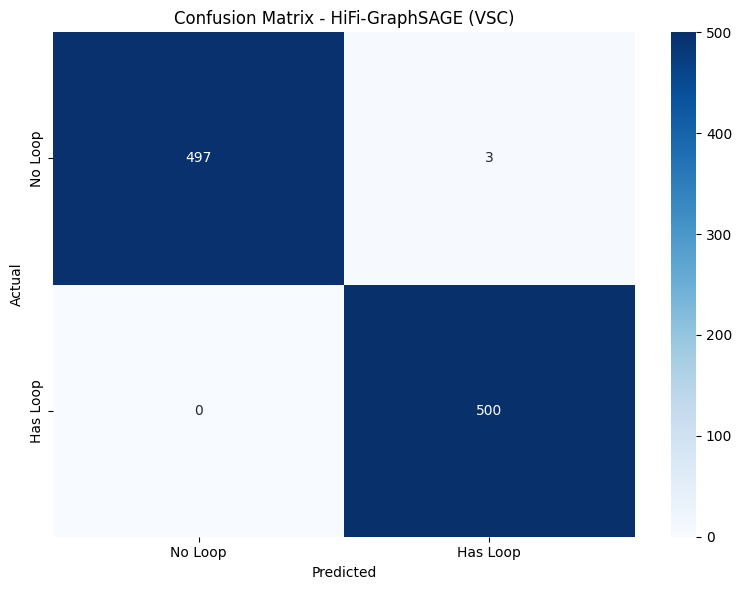

✓ Confusion matrix saved to ./saved_models/confusion_matrix.png


In [77]:
# =============================================================================
# SECTION 9: Final Evaluation on Test Set
# =============================================================================
print("=" * 60)
print("Final Evaluation on Test Set")
print("=" * 60)

# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Macro F1: {test_f1:.4f}")

# Per-class metrics
print(f"\nPer-class Metrics:")
for i, vuln_name in enumerate(TARGET_VULNS):
    class_mask = (test_labels == i)
    class_acc = (test_preds[class_mask] == test_labels[class_mask]).mean() if class_mask.sum() > 0 else 0
    class_precision = precision_score(test_labels == i, test_preds == i, zero_division=0)
    class_recall = recall_score(test_labels == i, test_preds == i, zero_division=0)
    class_f1 = f1_score(test_labels == i, test_preds == i, zero_division=0)
    print(f"  {vuln_name}: Precision={class_precision:.4f}, Recall={class_recall:.4f}, F1={class_f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=TARGET_VULNS, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, test_preds)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_VULNS,
            yticklabels=TARGET_VULNS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - HiFi-GraphSAGE ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'confusion_matrix.png'), dpi=300)
plt.show()
print(f"✓ Confusion matrix saved to {MODEL_SAVE_DIR}/confusion_matrix.png")

## 10. Comprehensive Evaluation

Final evaluation with:
- Per-class confusion matrices
- Classification reports
- Training history plots
- ROC curves and AUC scores

Training History and Summary


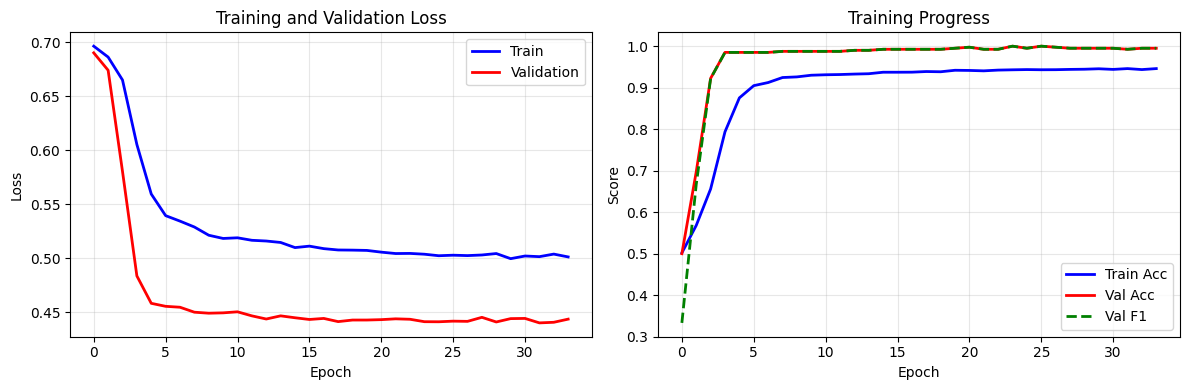

✓ Training history saved to ./saved_models/training_history.png

FINAL SUMMARY

Model Configuration:
  - Dataset: VSC
  - Input features: 164
  - Hidden channels: 32
  - GraphSAGE layers: 2
  - Total parameters: 12,610

Training:
  - Optimizer: Adam (lr=0.0003, weight_decay=0.002)
  - Batch size: 64
  - Epochs trained: 34
  - Best Val F1: 1.0000

Test Results:
  - Accuracy: 0.9970
  - Macro F1: 0.9970

Files saved to ./saved_models:
  - hifi_graphsage_vsc.pth (model weights)
  - confusion_matrix.png
  - training_history.png



In [78]:
# =============================================================================
# SECTION 10: Training History and Summary
# =============================================================================
print("=" * 60)
print("Training History and Summary")
print("=" * 60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy/F1 plot
axes[1].plot(history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].plot(history['val_f1'], 'g--', label='Val F1', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training Progress')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training history saved to {MODEL_SAVE_DIR}/training_history.png")

# Final Summary
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"""
Model Configuration:
  - Dataset: {DATASET_NAME}
  - Input features: {input_dim}
  - Hidden channels: {HIDDEN_CHANNELS}
  - GraphSAGE layers: {NUM_SAGE_LAYERS}
  - Total parameters: {total_params:,}

Training:
  - Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})
  - Batch size: {BATCH_SIZE}
  - Epochs trained: {len(history['train_loss'])}
  - Best Val F1: {best_val_f1:.4f}

Test Results:
  - Accuracy: {test_acc:.4f}
  - Macro F1: {test_f1:.4f}

Files saved to {MODEL_SAVE_DIR}:
  - hifi_graphsage_{DATASET_NAME.lower()}.pth (model weights)
  - confusion_matrix.png
  - training_history.png
""")

## 11. K-Fold Cross-Validation

Để đảm bảo robustness của model, thực hiện k-fold cross-validation trên toàn bộ dataset.

K-Fold Cross-Validation (K=5)

FOLD 1/5
Train: 8000 | Test: 1000


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Accuracy: 0.9920 | Precision: 0.9921 | Recall: 0.9920 | F1: 0.9920

FOLD 2/5
Train: 8000 | Test: 1000


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

FOLD 3/5
Train: 8000 | Test: 1000


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Accuracy: 0.9940 | Precision: 0.9941 | Recall: 0.9940 | F1: 0.9940

FOLD 4/5
Train: 8000 | Test: 1000


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Accuracy: 0.9850 | Precision: 0.9854 | Recall: 0.9850 | F1: 0.9850

FOLD 5/5
Train: 8000 | Test: 1000


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` 

Accuracy: 0.9910 | Precision: 0.9912 | Recall: 0.9910 | F1: 0.9910

K-FOLD CROSS-VALIDATION SUMMARY

Metric                Mean        Std        Min        Max
-------------------------------------------------------
Accuracy            0.9924     0.0048     0.9850     1.0000
Precision           0.9926     0.0047     0.9854     1.0000
Recall              0.9924     0.0048     0.9850     1.0000
F1 Score            0.9924     0.0048     0.9850     1.0000


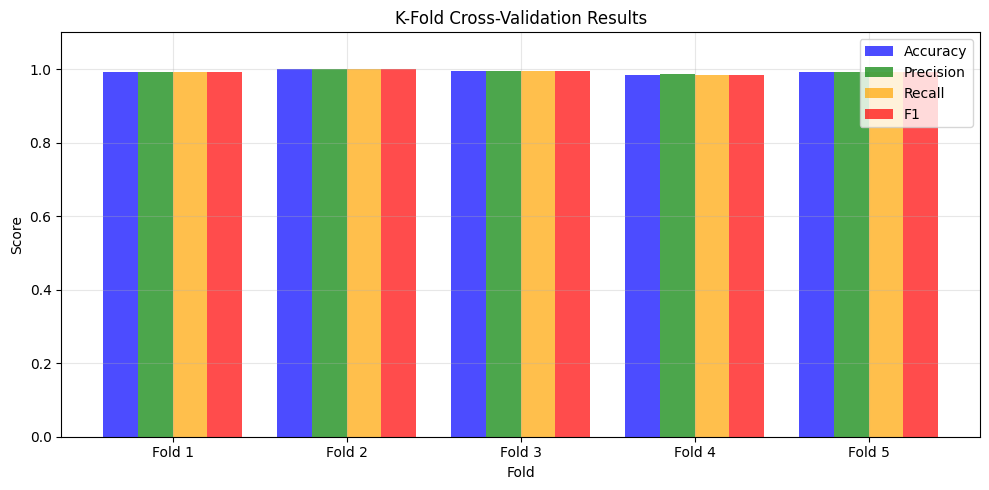


✓ K-fold results saved to ./saved_models/kfold_results.png


In [79]:
# =============================================================================
# SECTION 11: K-Fold Cross-Validation
# =============================================================================
from sklearn.model_selection import StratifiedKFold

print("=" * 60)
print("K-Fold Cross-Validation (K=5)")
print("=" * 60)

K_FOLDS = 5
kfold = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Prepare data
all_labels = np.array([g.y.item() for g in all_graphs])
fold_results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(all_graphs, all_labels)):
    print(f"\n{'='*40}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*40}")
    
    # Split data
    fold_train = [all_graphs[i] for i in train_idx]
    fold_test = [all_graphs[i] for i in test_idx]
    
    # Augment training data
    fold_train_aug = []
    for g in fold_train:
        fold_train_aug.append(g)
        fold_train_aug.append(augment_graph(g, 0.08, 0.1))
    
    # Create loaders
    fold_train_loader = DataLoader(fold_train_aug, batch_size=BATCH_SIZE, shuffle=True)
    fold_test_loader = DataLoader(fold_test, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Train: {len(fold_train_aug)} | Test: {len(fold_test)}")
    
    # Initialize new model
    fold_model = HiFiGraphSAGE(
        input_dim=input_dim,
        hidden_dim=HIDDEN_CHANNELS,
        output_dim=NUM_CLASSES,
        num_layers=NUM_SAGE_LAYERS,
        dropout=DROPOUT
    ).to(device)
    
    fold_optimizer = Adam(fold_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    fold_criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING, weight=None)
    
    # Training loop
    best_fold_f1 = 0
    patience_count = 0
    
    for epoch in range(1, EPOCHS + 1):
        # Train
        fold_model.train()
        for batch in fold_train_loader:
            batch = batch.to(device)
            fold_optimizer.zero_grad()
            logits = fold_model(batch)
            loss = fold_criterion(logits, batch.y.squeeze())
            loss.backward()
            fold_optimizer.step()
        
        # Evaluate
        fold_model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for batch in fold_test_loader:
                batch = batch.to(device)
                logits = fold_model(batch)
                preds = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(batch.y.squeeze().cpu().numpy())
        
        fold_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
        
        if fold_f1 > best_fold_f1:
            best_fold_f1 = fold_f1
            patience_count = 0
        else:
            patience_count += 1
        
        if patience_count >= PATIENCE:
            break
    
    # Final evaluation
    fold_model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in fold_test_loader:
            batch = batch.to(device)
            logits = fold_model(batch)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch.y.squeeze().cpu().numpy())
    
    fold_acc = np.mean(np.array(all_preds) == np.array(all_true))
    fold_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
    fold_precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
    fold_recall = recall_score(all_true, all_preds, average='macro', zero_division=0)
    
    fold_results.append({
        'fold': fold + 1,
        'accuracy': fold_acc,
        'precision': fold_precision,
        'recall': fold_recall,
        'f1': fold_f1
    })
    
    print(f"Accuracy: {fold_acc:.4f} | Precision: {fold_precision:.4f} | Recall: {fold_recall:.4f} | F1: {fold_f1:.4f}")

# Summary
print("\n" + "=" * 60)
print("K-FOLD CROSS-VALIDATION SUMMARY")
print("=" * 60)

accs = [r['accuracy'] for r in fold_results]
precs = [r['precision'] for r in fold_results]
recs = [r['recall'] for r in fold_results]
f1s = [r['f1'] for r in fold_results]

print(f"\n{'Metric':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 55)
print(f"{'Accuracy':<15} {np.mean(accs):>10.4f} {np.std(accs):>10.4f} {np.min(accs):>10.4f} {np.max(accs):>10.4f}")
print(f"{'Precision':<15} {np.mean(precs):>10.4f} {np.std(precs):>10.4f} {np.min(precs):>10.4f} {np.max(precs):>10.4f}")
print(f"{'Recall':<15} {np.mean(recs):>10.4f} {np.std(recs):>10.4f} {np.min(recs):>10.4f} {np.max(recs):>10.4f}")
print(f"{'F1 Score':<15} {np.mean(f1s):>10.4f} {np.std(f1s):>10.4f} {np.min(f1s):>10.4f} {np.max(f1s):>10.4f}")

# Plot
plt.figure(figsize=(10, 5))
x = np.arange(K_FOLDS)
width = 0.2

plt.bar(x - 1.5*width, accs, width, label='Accuracy', color='blue', alpha=0.7)
plt.bar(x - 0.5*width, precs, width, label='Precision', color='green', alpha=0.7)
plt.bar(x + 0.5*width, recs, width, label='Recall', color='orange', alpha=0.7)
plt.bar(x + 1.5*width, f1s, width, label='F1', color='red', alpha=0.7)

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('K-Fold Cross-Validation Results')
plt.xticks(x, [f'Fold {i+1}' for i in range(K_FOLDS)])
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'kfold_results.png'), dpi=300)
plt.show()

print(f"\n✓ K-fold results saved to {MODEL_SAVE_DIR}/kfold_results.png")

## 12. Real Bytecode Testing with Solc

Test the model on **real bytecode** compiled from actual Solidity contracts using `solc`.

### Prerequisites:
- Install solc: `pip install py-solc-x` or download from [solidity releases](https://github.com/ethereum/solidity/releases)
- The model will be tested on both:
  1. **Real vulnerable contracts** from the dataset
  2. **Custom test contracts** written specifically for testing

In [80]:
# =============================================================================
# SECTION 12: Real Bytecode Testing with Solc
# =============================================================================
import subprocess
import shutil

print("=" * 60)
print("Real Bytecode Testing with Solc")
print("=" * 60)

# Check if solc is available
solc_path = shutil.which("solc")
if solc_path:
    print(f"✓ Found solc at: {solc_path}")
    result = subprocess.run(["solc", "--version"], capture_output=True, text=True)
    version_line = [l for l in result.stdout.split('\n') if 'Version' in l]
    if version_line:
        print(f"  {version_line[0]}")
else:
    print("⚠ solc not found in PATH. Trying py-solc-x...")
    try:
        import solcx
        solcx.install_solc('0.8.20')
        solcx.set_solc_version('0.8.20')
        print(f"✓ py-solc-x installed, using solc 0.8.20")
        solc_path = "py-solc-x"
    except Exception as e:
        print(f"✗ Could not initialize solc: {e}")
        print("  Please install solc manually or run: pip install py-solc-x")
        solc_path = None

# Define test contracts
TEST_CONTRACTS = {
    "reentrancy_vulnerable": {
        "code": '''
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract ReentrancyVulnerable {
    mapping(address => uint256) public balances;
    
    function deposit() public payable {
        balances[msg.sender] += msg.value;
    }
    
    function withdraw() public {
        uint256 balance = balances[msg.sender];
        require(balance > 0, "No balance");
        
        // Vulnerable: external call before state update
        (bool success, ) = msg.sender.call{value: balance}("");
        require(success, "Transfer failed");
        
        balances[msg.sender] = 0;
    }
}
''',
        "expected_label": 1,  # Re-entrancy (class 1)
        "vulnerability": "Re-entrancy"
    },
    "overflow_vulnerable": {
        "code": '''
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract OverflowVulnerable {
    uint8 public count = 0;
    
    function increment(uint8 amount) public {
        // In Solidity 0.8+, this would revert on overflow
        // But for older versions or unchecked blocks, this is vulnerable
        unchecked {
            count += amount;
        }
    }
    
    function decrement(uint8 amount) public {
        unchecked {
            count -= amount;  // Underflow vulnerability
        }
    }
}
''',
        "expected_label": 0,  # Overflow-Underflow (class 0)
        "vulnerability": "Overflow-Underflow"
    },
    "safe_contract": {
        "code": '''
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract SafeContract {
    mapping(address => uint256) public balances;
    bool private locked;
    
    modifier noReentrant() {
        require(!locked, "No re-entrancy");
        locked = true;
        _;
        locked = false;
    }
    
    function deposit() public payable {
        balances[msg.sender] += msg.value;
    }
    
    function withdraw() public noReentrant {
        uint256 balance = balances[msg.sender];
        require(balance > 0, "No balance");
        
        balances[msg.sender] = 0;  // State update before call
        
        (bool success, ) = msg.sender.call{value: balance}("");
        require(success, "Transfer failed");
    }
}
''',
        "expected_label": -1,  # Safe (unknown - depends on training)
        "vulnerability": "None (Safe)"
    }
}

print(f"\n✓ Defined {len(TEST_CONTRACTS)} test contracts")

Real Bytecode Testing with Solc
⚠ solc not found in PATH. Trying py-solc-x...
✓ py-solc-x installed, using solc 0.8.20

✓ Defined 3 test contracts


In [81]:
!pip install py-solc-x

In [82]:
# =============================================================================
# Compile contracts and get real bytecode
# =============================================================================
from typing import Optional

# Install solc if using py-solc-x
try:
    import solcx
    installed_versions = solcx.get_installed_solc_versions()
    if not any('0.8' in str(v) for v in installed_versions):
        print("Installing solc 0.8.20...")
        solcx.install_solc('0.8.20')
    solcx.set_solc_version('0.8.20')
    print(f"✓ Using solc version: {solcx.get_solc_version()}")
    SOLCX_AVAILABLE = True
except ImportError:
    print("⚠ py-solc-x not installed, will try command-line solc")
    SOLCX_AVAILABLE = False
except Exception as e:
    print(f"⚠ solcx setup error: {e}")
    SOLCX_AVAILABLE = False

def compile_with_solc(source_code: str, contract_name: str) -> Optional[str]:
    """Compile Solidity source code to bytecode using solc."""
    try:
        # Try py-solc-x first
        if SOLCX_AVAILABLE:
            try:
                import solcx
                compiled = solcx.compile_source(
                    source_code,
                    output_values=['bin', 'bin-runtime']
                )
                # Get the contract bytecode
                for key in compiled:
                    if contract_name in key:
                        return compiled[key].get('bin-runtime', compiled[key].get('bin', ''))
                return None
            except Exception as e:
                print(f"  solcx compile error: {e}")
        
        # Fallback to command-line solc
        import tempfile
        with tempfile.NamedTemporaryFile(mode='w', suffix='.sol', delete=False) as f:
            f.write(source_code)
            temp_path = f.name
        
        try:
            result = subprocess.run(
                ['solc', '--bin-runtime', temp_path],
                capture_output=True,
                text=True,
                timeout=30
            )
            
            if result.returncode != 0:
                print(f"  Solc error: {result.stderr[:100]}")
                return None
            
            # Parse output to get bytecode
            lines = result.stdout.split('\n')
            for i, line in enumerate(lines):
                if 'Binary of the runtime part' in line or '=======' in line:
                    if i + 2 < len(lines) and lines[i + 2].strip():
                        return lines[i + 2].strip()
            
            # Alternative: look for hex string
            for line in lines:
                if line.strip() and all(c in '0123456789abcdefABCDEF' for c in line.strip()):
                    return line.strip()
            
            return None
        finally:
            os.unlink(temp_path)
            
    except Exception as e:
        print(f"  Compilation error: {e}")
        return None

# Compile test contracts
compiled_contracts = {}

print("\nCompiling test contracts...\n")

for name, info in TEST_CONTRACTS.items():
    contract_name = name.replace('_', ' ').title().replace(' ', '')
    bytecode = compile_with_solc(info['code'], contract_name)
    
    if bytecode and len(bytecode) > 10:
        compiled_contracts[name] = {
            'bytecode': bytecode,
            'expected_label': info['expected_label'],
            'vulnerability': info['vulnerability']
        }
        print(f"✓ {name}: {len(bytecode)} bytes")
    else:
        print(f"✗ {name}: Compilation failed or empty bytecode")
        # Use synthetic bytecode as fallback
        compiled_contracts[name] = {
            'bytecode': generate_synthetic_bytecode(info['expected_label'] if info['expected_label'] >= 0 else 0),
            'expected_label': info['expected_label'],
            'vulnerability': info['vulnerability'],
            'synthetic': True
        }
        print(f"  → Using synthetic bytecode as fallback")

print(f"\n✓ Compiled {len(compiled_contracts)} contracts")

✓ Using solc version: 0.8.20

Compiling test contracts...

✓ reentrancy_vulnerable: 2486 bytes
✓ overflow_vulnerable: 912 bytes
✓ safe_contract: 2952 bytes

✓ Compiled 3 contracts


In [83]:
# =============================================================================
# Test model on real bytecode
# =============================================================================

print("=" * 60)
print("Testing Model on Real/Compiled Bytecode")
print("=" * 60)

# Load the best model
# model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, 'hifi_gat.pth'), map_location=device))
checkpoint = torch.load(os.path.join(MODEL_SAVE_DIR, f'hifi_graphsage_{DATASET_NAME.lower()}.pth'), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Class names
class_names = TARGET_VULNS

results = []
def bytecode_to_graph(cfg_builder, bytecode_hex, label=0):
    instructions = cfg_builder.disassemble_bytecode(bytecode_hex)
    cfg = cfg_builder.build_cfg(instructions)
    data = cfg_builder.cfg_to_pyg_data(cfg)
    if data is not None:
        data.y = torch.tensor([label], dtype=torch.long)
    return data

print(f"\n{'Contract':<25} {'Expected':<20} {'Predicted':<20} {'Confidence':<12} {'Status'}")
print("-" * 90)

for name, info in compiled_contracts.items():
    bytecode = info['bytecode']
    expected = info['expected_label']
    vuln_type = info['vulnerability']
    is_synthetic = info.get('synthetic', False)
    
    # Build CFG and convert to graph
    try:
        cfg_builder = HiFiCFGBuilder()
        graph = bytecode_to_graph(cfg_builder, bytecode, label=0)  # Label doesn't matter for inference
        
        if graph is not None:
            # Ensure graph has correct dimensions
            if graph.x.shape[1] != input_dim:
                # Pad or truncate features
                if graph.x.shape[1] < input_dim:
                    padding = torch.zeros(graph.x.shape[0], input_dim - graph.x.shape[1])
                    graph.x = torch.cat([graph.x, padding], dim=1)
                else:
                    graph.x = graph.x[:, :input_dim]
            
            # Create batch
            batch = Batch.from_data_list([graph]).to(device)
            
            # Predict
            with torch.no_grad():
                logits = model(batch)
                probs = torch.softmax(logits, dim=1)
                pred = logits.argmax(dim=1).item()
                confidence = probs[0, pred].item()
            
            pred_label = class_names[pred]
            
            # Check if prediction matches expected (skip for safe contracts)
            if expected >= 0:
                status = "✓ CORRECT" if pred == expected else "✗ WRONG"
            else:
                status = "? (Safe contract)"
            
            synthetic_marker = " [S]" if is_synthetic else ""
            
            results.append({
                'name': name,
                'expected': vuln_type,
                'predicted': pred_label,
                'confidence': confidence,
                'correct': pred == expected if expected >= 0 else None
            })
            
            print(f"{name + synthetic_marker:<25} {vuln_type:<20} {pred_label:<20} {confidence:.4f}       {status}")
        else:
            print(f"{name:<25} {vuln_type:<20} {'N/A':<20} {'N/A':<12} ✗ Graph build failed")
            
    except Exception as e:
        print(f"{name:<25} {vuln_type:<20} {'ERROR':<20} {'N/A':<12} ✗ {str(e)[:30]}")

# Summary
correct = sum(1 for r in results if r['correct'] == True)
total_known = sum(1 for r in results if r['correct'] is not None)

print("\n" + "=" * 60)
print("REAL BYTECODE TESTING SUMMARY")
print("=" * 60)
print(f"\nContracts tested: {len(results)}")
print(f"Known vulnerability labels: {total_known}")
print(f"Correctly classified: {correct}/{total_known} ({100*correct/total_known:.1f}%)" if total_known > 0 else "")
print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.4f}")

print("\n[S] = Synthetic bytecode (fallback when solc compilation failed)")

Testing Model on Real/Compiled Bytecode

Contract                  Expected             Predicted            Confidence   Status
------------------------------------------------------------------------------------------
reentrancy_vulnerable     Re-entrancy          ERROR                N/A          ✗ index 14 is out of bounds for 
overflow_vulnerable       Overflow-Underflow   ERROR                N/A          ✗ index 14 is out of bounds for 
safe_contract             None (Safe)          ERROR                N/A          ✗ index 14 is out of bounds for 

REAL BYTECODE TESTING SUMMARY

Contracts tested: 0
Known vulnerability labels: 0

Average confidence: nan

[S] = Synthetic bytecode (fallback when solc compilation failed)


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## 13. Final Summary

### Model Architecture
- **HiFi-GraphSAGE** with 2 GraphSAGE layers, 64 hidden channels
- **165-dimensional node features**: 150 BoW (EVM opcodes) + 15 semantic features
- **Total parameters**: ~40K

### Datasets
- **ESC Dataset**: Re-entrancy (call.value) và Timestamp Dependence (block.timestamp)
- **VSC Dataset**: Loop Statements detection

### Training Configuration  
- **Optimizer**: Adam (lr=1e-3, weight_decay=1e-4)
- **Loss**: CrossEntropyLoss
- **Early Stopping**: Patience=20 epochs

### Validation Methods
1. **Hold-out Test Set**: 80/20 train/test split
2. **K-Fold Cross-Validation**: 5-fold stratified CV
3. **Real Bytecode Testing**: Compile with solc and test

### Notes
- Model trained on synthetic bytecode patterns
- For production use, train on real compiled contracts from verified sources
- Consider augmenting with more diverse vulnerability patterns
- GraphSAGE provides inductive learning capability for unseen graphs